In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import warnings
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import glob
import xarray as xr
import xbudget
import regionate
import xwmt
import xwmb
import xgcm
import cartopy.crs as ccrs
import CM4Xutils #needed to run pip install nc-time-axis
from regionate import MaskRegions, GriddedRegion
import seaborn as sns

sns.set_style("whitegrid")
import matplotlib.pyplot as plt
import matplotlib as mpl

dpi = 200
mpl.rcParams['figure.dpi'] = dpi
sns.set_context("notebook")

import pandas as pd
import sys
sys.path.insert(0, '/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/src')
from src import *

### Load in data

In [4]:
savedir = "/vortexfs1/home/anthony.meza/scratch/CM4X/CM4XTransientTracers/data/model/"

In [5]:
ds = xr.open_dataset(
        datadir("/model/Southern_Ocean_WMT_Budget.nc"))

ds["BF_Adv"] = ds["surface_ocean_flux_advective_negative_rhs"]
ds["BF_NonAdv"] = ds["boundary_fluxes"] - ds["BF_Adv"]


ds["boundary_fluxes_heat"] = ds["surface_ocean_flux_advective_negative_rhs_heat"] +\
                                 ds["surface_exchange_flux_heat"] +\
                                 ds["frazil_ice_heat"] + ds["bottom_flux_heat"]

ds["boundary_fluxes_salt"] = ds["surface_ocean_flux_advective_negative_rhs_salt"] +\
                                 ds["surface_exchange_flux_salt"]


### Extract water mass budget

The closed numerical $\lambda$-WMT budget is given in Drake et. al 2024's Equation 43. The budget is given by: 
$$-\partial_t \mathcal{M}_\geq + \mathcal{S}_\geq + \Psi_\geq + \mathcal{G}^{BF}_\geq + \mathcal{G}^{Mix}_\geq + \mathcal{G}^{Spurious}_\geq = 0$$

Here: 
- $ \mathcal{M}(\tilde \lambda, t)_\geq = \int_\Omega \rho dV $ is the set of all waters bounded by a material surface $\tilde \lambda$
-  $\partial_t \mathcal{M}_\geq$ the rate of change of the mass of that water that is bounded by $\tilde \lambda$
    - $\tilde \lambda$ can be a density, so that $\partial_t \mathcal{M}_\geq$ describes the actual mass of waters denser than $\tilde \lambda$
    - When $\tilde \lambda$ is a density surface, $\partial_t \mathcal{M}_\geq > 0$ implies the mass of waters denser than $\tilde \lambda$ is decreasing
- If the region $\omega$ contains open boundaries (i.e. the focus is on a particular ocean), then mass is not conserved. Mass can enter freely via ocean circulation. This movement of mass along the horizontal boundaries is given by $\Psi_\geq$.
- $\mathcal{G}^{BF}_\geq$ is the contribution of mass change from boundary fluxes including mixing processes at the surface, seafloor and sea-ice.
- $\mathcal{G}^{Mix}_\geq$ includes the effects of parameterized mixing
- $\mathcal{G}^{Spurious}_\geq$ includes the effects of spurios mixing, from a models advection scheme. Obtained as a residual. 


In [6]:
integrate = lambda dx: np.cumsum(np.concatenate([[0], dx.values]))

In [7]:
sigma = 37.00
toSv = 1/1035*1e-6
toTg = 1e-9 

mass_flux_units = "Tg/s"
mass_flux_units_conversion = toTg

expt_colors = dict(); expt_colors["control"] = "#2f74b3"; expt_colors["forced"] = "#cc415a"

In [8]:
experiments = ['forced', 'control']
nexpt = len(experiments)

budgets = ['mass_tendency', 
           'boundary_fluxes_heat',
           'boundary_fluxes_salt',
           'diffusion', 
           'spurious_numerical_mixing',
           'convergent_mass_transport', 
           'mass_source', 
           ]

budgets_labels = [r"$\partial_{t} \mathcal{M}$", 
                  r"$\mathcal{G}^{BF, \theta}$",
                  r"$\mathcal{G}^{BF, S}$",
                  r"$\mathcal{G}^{mix}$",
                  r"$\mathcal{G}^{Spu}$",
                  r"$\Psi$", 
                  r"$\mathcal{S}$", 
                  ]
times = [("2050", "2100")]

ncols = len(times)

-10.647369260573338
0.9552911562541643


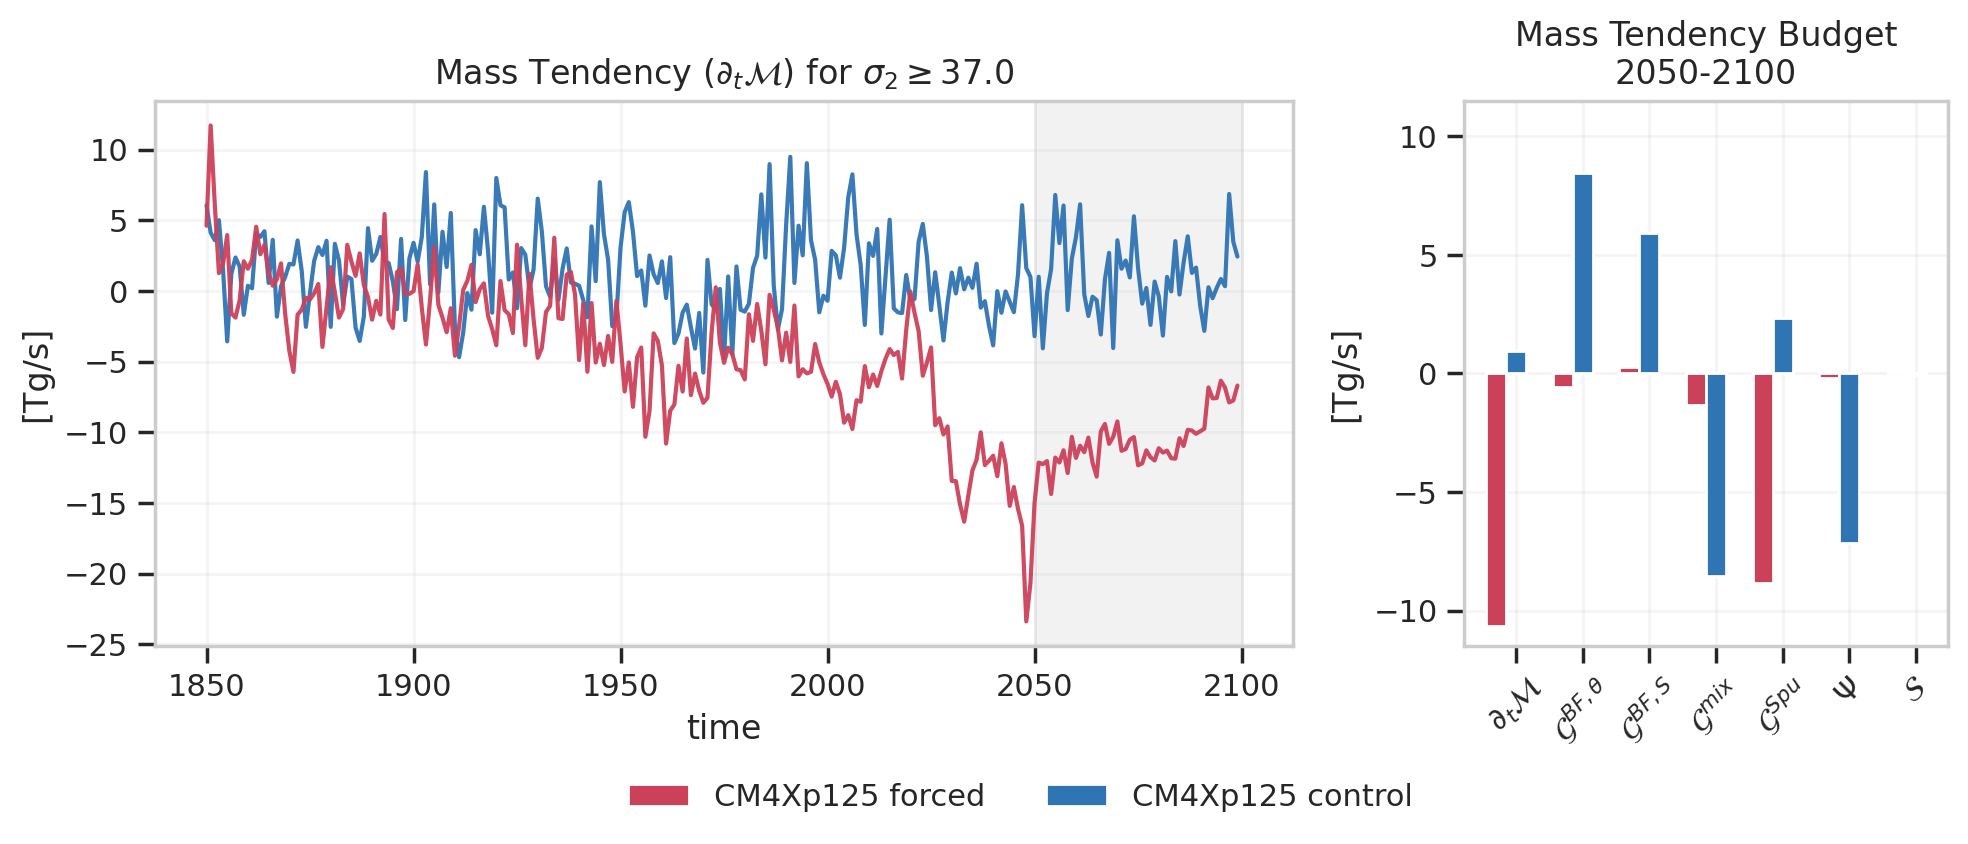

In [9]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Create a figure
fig = plt.figure(figsize=(10, 4))

# Create a GridSpec with 4 columns, where the first plot takes up 3/4 and the second takes 1/4
gs = gridspec.GridSpec(1, 6)

###### PLOT 1. TIME SERIES ###########
ax = fig.add_subplot(gs[0, :4])

ax.grid(alpha = 0.4, axis = "y")
width = 0.3

tendencies = mass_flux_units_conversion * ds.sel(sigma2_l_target = sigma, method = "nearest").compute()
tendencies = tendencies.groupby("time.year").mean("time")
tendencies = tendencies.sel(year = slice("1850", None))
ax.grid(alpha = 0.2)

ax.plot(tendencies.year, tendencies["mass_tendency"].sel(exp = "control"), 
        label = "CM4Xp125\ncontrol", linewidth = 1.5, alpha = 0.95, c = expt_colors["control"])

ax.plot(tendencies.year, tendencies["mass_tendency"].sel(exp = "forced"), 
        label = "CM4Xp125\nforced", linewidth = 1.5, alpha = 0.95, c = expt_colors["forced"])

ax.set_ylabel(f"[{mass_flux_units}]")

ax.set_title("Mass Tendency " + r"$(\partial_{t} \mathcal{M})$" + " for " + r"$\sigma_2 \geq 37.0$")
ax.set_xlabel("time")
ax.tick_params(bottom=True, left=True)

ax.axvspan(2050, 2100, color='grey' , alpha=0.1, zorder = 0)

###### PLOT 2. BAR PLOT ###########
ax = fig.add_subplot(gs[0, 4:])
for (it, t) in enumerate(times):
    wmt_mean = mass_flux_units_conversion * ds.sel(sigma2_l_target = sigma, method = "nearest")
    wmt_mean = wmt_mean.sel(time = slice(t[0], t[1])).mean("time")
    curr_width = 0.0
    for (i, exp) in enumerate(experiments):

        wmt_mean_budget =  wmt_mean.sel(exp = exp)
        print(wmt_mean_budget['mass_tendency'].values)
        bvalues = [wmt_mean_budget[k].values for k in budgets]
    
        nterms = np.arange(len(budgets_labels))
    
        ax.bar(nterms + curr_width, bvalues, label = "CM4Xp125 " + exp, 
                  width = width, color = expt_colors[exp])
        curr_width += width
    
ax.grid(alpha = 0.2)
ax.set_ylim(-11.5, 11.5)
ax.set_xticks(np.arange(len(budgets_labels)) + width, budgets_labels, rotation = 45)
ax.set_title("Mass Tendency Budget\n" + '-'.join(t))
ax.set_ylabel(f"[{mass_flux_units}]")
fig.tight_layout()
ax.legend(ncols = 2, bbox_to_anchor = (-0.05, -0.2), frameon = False)
ax.tick_params(bottom=True, left=True, labelleft=True)
# fig.subplots_adjust(wspace = 0.2)
fig.savefig(plotsdir("paper_figures/dMdt_sigma_37.png"), bbox_inches = "tight", dpi = dpi)

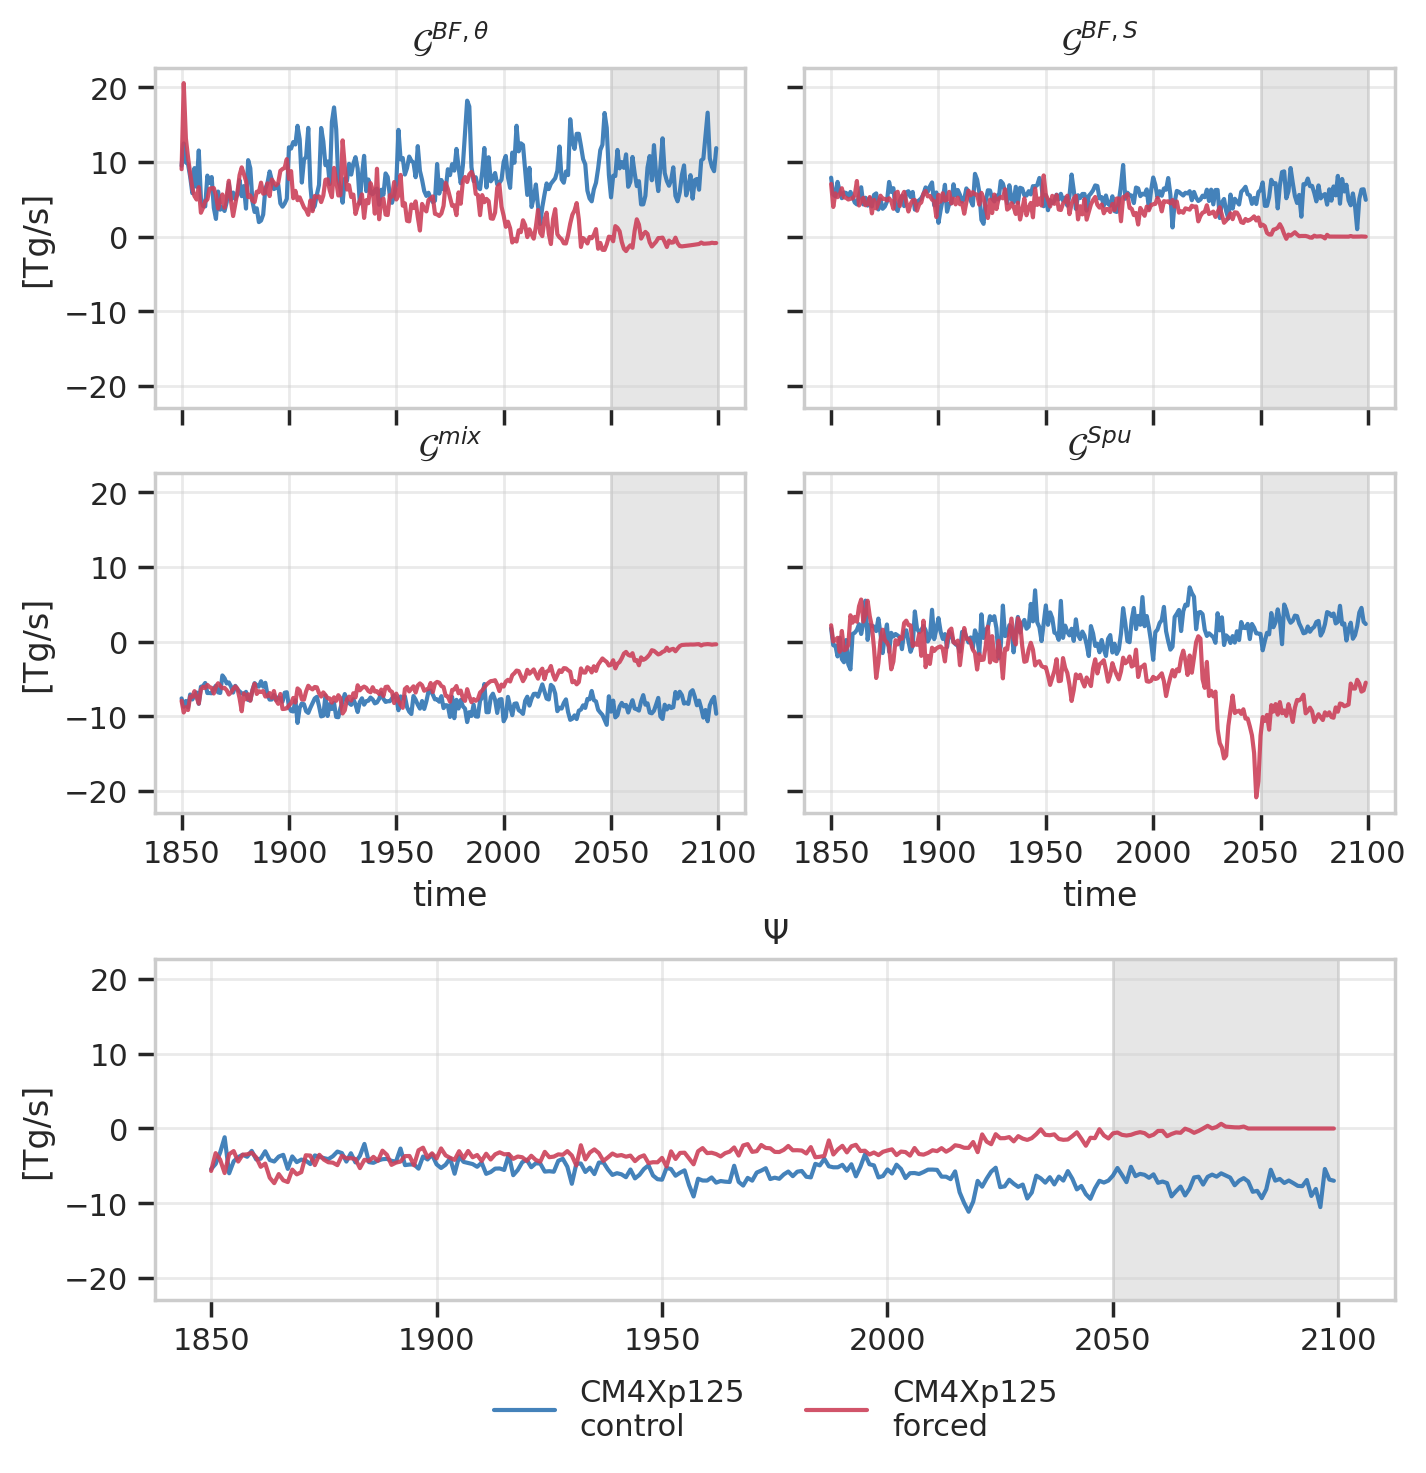

In [10]:
tendencies = mass_flux_units_conversion * ds.sel(sigma2_l_target = sigma, method = "nearest").compute()

tendencies_std = tendencies.groupby("time.year").std("time")
tendencies_std = tendencies_std.sel(year = slice("1850", None))

tendencies = tendencies.groupby("time.year").mean("time")
tendencies = tendencies.sel(year = slice("1850", None))

budget_colors = sns.color_palette("Dark2")

budgets = ['boundary_fluxes_heat',
           'boundary_fluxes_salt',
           'diffusion', 
           'spurious_numerical_mixing',
           'convergent_mass_transport', 
           ]

budgets_labels = [r"$\mathcal{G}^{BF, \theta}$",
                  r"$\mathcal{G}^{BF, S}$",
                  r"$\mathcal{G}^{mix}$",
                  r"$\mathcal{G}^{Spu}$",
                  r"$\Psi$", 
                  ]

# fig, axes = plt.subplots(1, len(budgets),  figsize = (10, 4), sharex = True, sharey = True)

fig = plt.figure(figsize=(8, 8))

# Create a GridSpec with 3 rows and 2 columns
gs = gridspec.GridSpec(4, 2, height_ratios=[1, 1, 0.05, 1])  # The last row is for spacing

# Create the top 4 subplots (2x2 grid) sharing both x and y axes with the first subplot
ax1 = fig.add_subplot(gs[0, 0])
axes = [ax1] + [fig.add_subplot(gs[i // 2, i % 2], sharex=ax1, sharey=ax1) for i in range(1, 4)]


# Create the bottom subplot spanning both columns in the 4th row and append it to the axes
ax5 = fig.add_subplot(gs[3, :], sharey=ax1)
axes.append(ax5)

for (j, expt) in enumerate(["control", "forced"]):
    for i in range(len(budgets)):
        ax = axes[i]
        ax.grid(alpha = 0.4)
        ax.plot(tendencies.year, tendencies[budgets[i]].sel(exp = expt), 
                label = f"CM4Xp125\n{expt}", linewidth = 1.5, 
                alpha = 0.9, c = expt_colors[expt])
            
        ax.tick_params(bottom=True, left=True)
        ax.axvspan(2050, 2100, color='grey' , alpha=0.1, zorder = 0)
        ax.set_title(budgets_labels[i])
        
axes[0].set_ylabel(f"[{mass_flux_units}]")
axes[2].set_ylabel(f"[{mass_flux_units}]")
axes[4].set_ylabel(f"[{mass_flux_units}]")

[ax.set_xlabel("time") for ax in axes[2:4]]
axes[0].tick_params(labelbottom=False)
axes[1].tick_params(labelbottom=False, labelleft = False)
axes[3].tick_params(labelleft = False)

fig.subplots_adjust(hspace = 0.25, wspace = 0.1)

axes[-1].legend(ncols = 6, bbox_to_anchor = (0.75, -0.15), frameon = False)

fig.savefig(plotsdir("paper_figures/budget_sigma_37.png"), bbox_inches = "tight", dpi = dpi)

### Seasonality of advection and mixing terms

#### Seasonality of advection terms

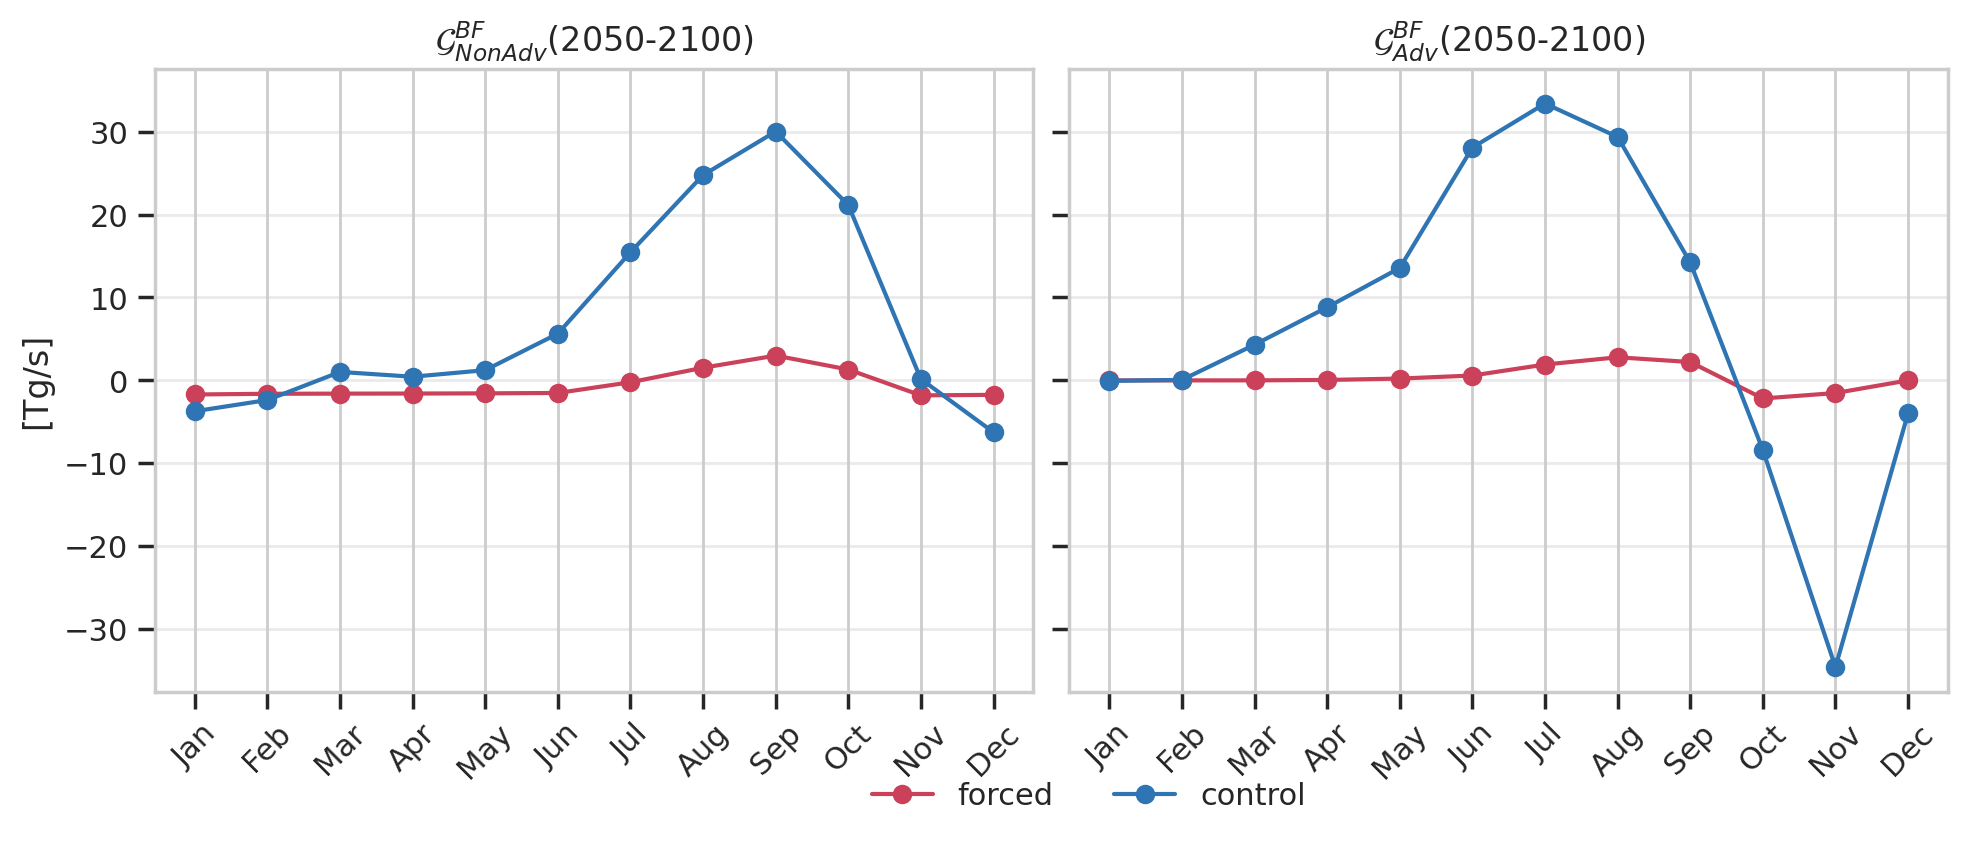

In [11]:
experiments = ['forced', 'control']
nexpt = len(experiments)

fig, ax = plt.subplots(1, 2, figsize = (10, 4), sharey = "row")

width = 0.25
times = ("2050", "2100")

wmt_mean = mass_flux_units_conversion * ds.sel(sigma2_l_target = sigma, method = "nearest")
wmt_mean = wmt_mean.sel(time = slice(times[0], times[1])).groupby("time.month").mean("time")

it = 0
ax[0].set_title(r"$\mathcal{G}^{BF}_{NonAdv} $" + '(' + '-'.join(t) + ')')
ax[1].set_title(r"$\mathcal{G}^{BF}_{Adv} $" + '(' +'-'.join(t) + ')')

max_flux =  np.abs(wmt_mean.sel(exp = "control")["BF_Adv"]).max() + 3

for (i, exp) in enumerate(experiments):
    wmt_mean_budget =  wmt_mean.sel(exp = exp)["BF_NonAdv"]
    ax[0].plot(wmt_mean_budget.month * 1.75, wmt_mean_budget, marker = "o", label = exp, color = expt_colors[exp])
    wmt_mean_budget =  wmt_mean.sel(exp = exp)["BF_Adv"]
    ax[1].plot(wmt_mean_budget.month * 1.75, wmt_mean_budget, marker = "o", label = exp, color = expt_colors[exp])

ax[0].set_ylabel(f"[{mass_flux_units}]")
fig.tight_layout()

months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
[a.set_xticks(wmt_mean_budget.month * 1.75, months, rotation = 45) for a in ax];
[a.grid(alpha = 0.4, axis = "y") for a in ax.flatten()]

# ax[0].set_ylabel(r"$\mathcal{G}^{BF}_{NonAdv} $" + " [Sv]")
ax[1].legend(ncols = 3, bbox_to_anchor = (0.3, -0.1), frameon = False)
ax[0].set_ylim(-max_flux, max_flux)
[a.tick_params(bottom=True, left=True) for a in ax];
fig.savefig(plotsdir("paper_figures/Gadv_sigma_37.png"), bbox_inches = "tight", dpi = dpi)

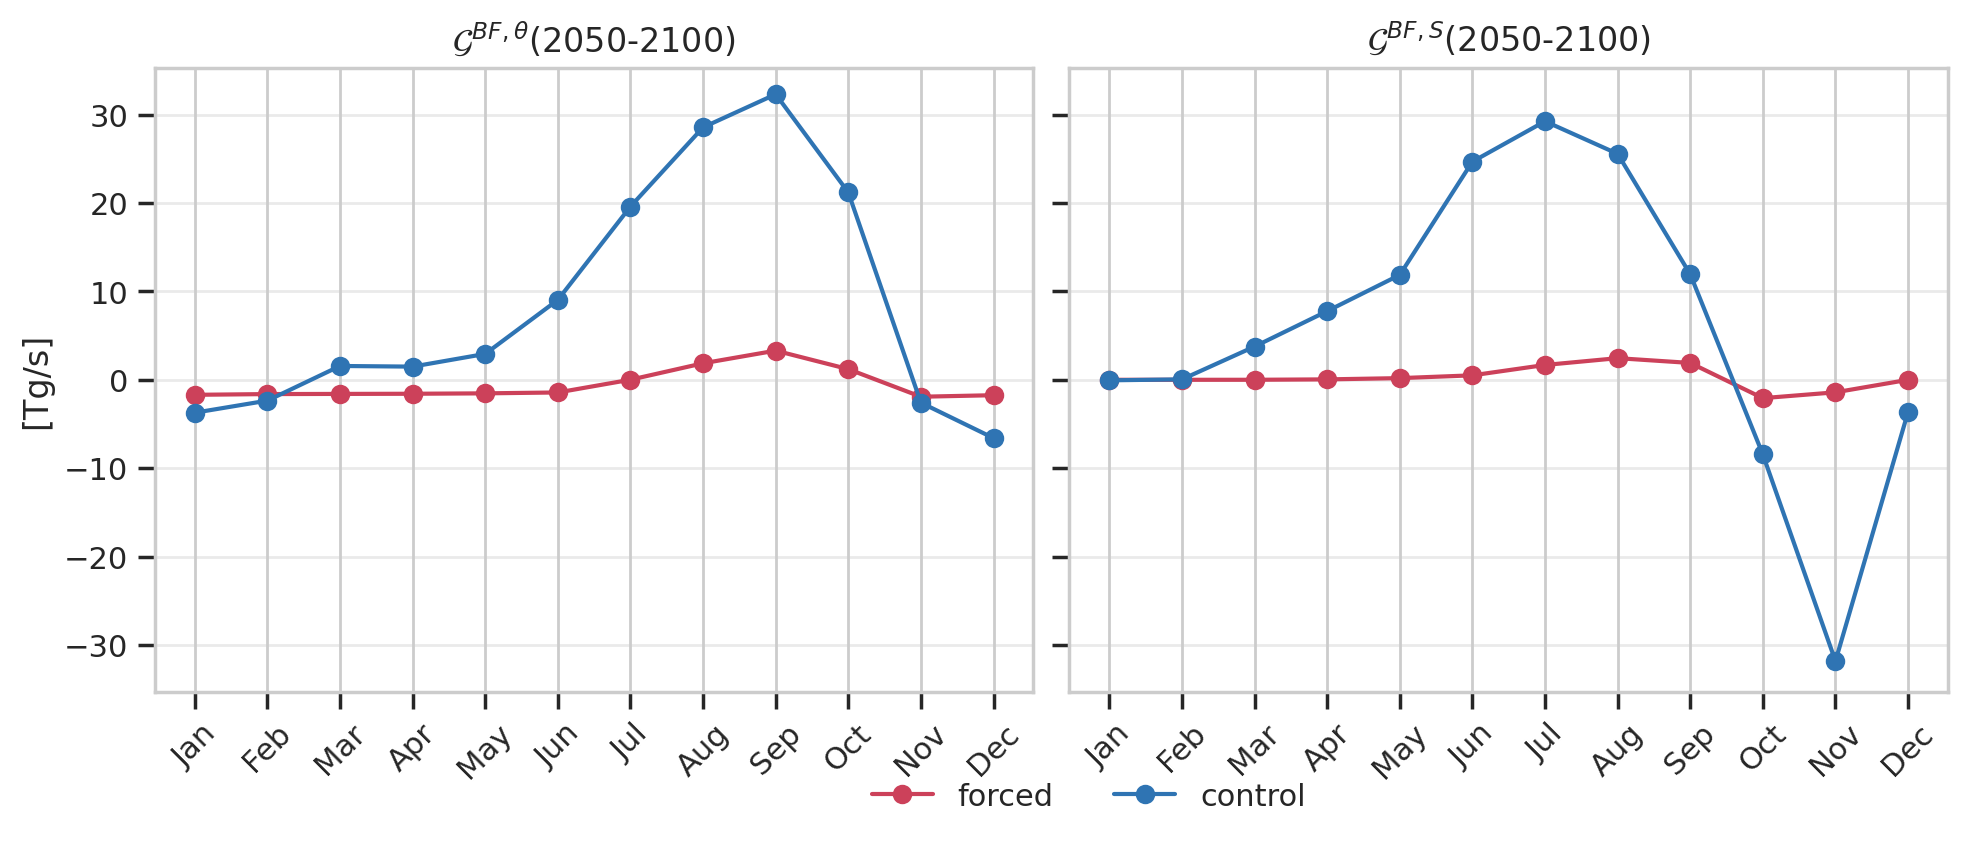

In [12]:
experiments = ['forced', 'control']
nexpt = len(experiments)

fig, ax = plt.subplots(1, 2, figsize = (10, 4), sharey = "row")

width = 0.25
times = ("2050", "2100")

wmt_mean = mass_flux_units_conversion * ds.sel(sigma2_l_target = sigma, method = "nearest")
wmt_mean = wmt_mean.sel(time = slice(times[0], times[1])).groupby("time.month").mean("time")

it = 0
ax[0].set_title(r"$\mathcal{G}^{BF, \theta}$" + '(' + '-'.join(t) + ')')
ax[1].set_title(r"$\mathcal{G}^{BF, S} $" + '(' +'-'.join(t) + ')')

max_flux =  np.abs(wmt_mean.sel(exp = "control")["boundary_fluxes_heat"]).max() + 3

for (i, exp) in enumerate(experiments):
    wmt_mean_budget =  wmt_mean.sel(exp = exp)["boundary_fluxes_heat"]
    ax[0].plot(wmt_mean_budget.month * 1.75, wmt_mean_budget, marker = "o", label = exp, color = expt_colors[exp])
    wmt_mean_budget =  wmt_mean.sel(exp = exp)["boundary_fluxes_salt"]
    ax[1].plot(wmt_mean_budget.month * 1.75, wmt_mean_budget, marker = "o", label = exp, color = expt_colors[exp])

ax[0].set_ylabel(f"[{mass_flux_units}]")
fig.tight_layout()

months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
[a.set_xticks(wmt_mean_budget.month * 1.75, months, rotation = 45) for a in ax];
[a.grid(alpha = 0.4, axis = "y") for a in ax.flatten()]

# ax[0].set_ylabel(r"$\mathcal{G}^{BF}_{NonAdv} $" + " [Sv]")
ax[1].legend(ncols = 3, bbox_to_anchor = (0.3, -0.1), frameon = False)
ax[0].set_ylim(-max_flux, max_flux)
[a.tick_params(bottom=True, left=True) for a in ax];
fig.savefig(plotsdir("paper_figures/GBF_sigma_37.png"), bbox_inches = "tight", dpi = dpi)

#### Seasonality of mixing terms

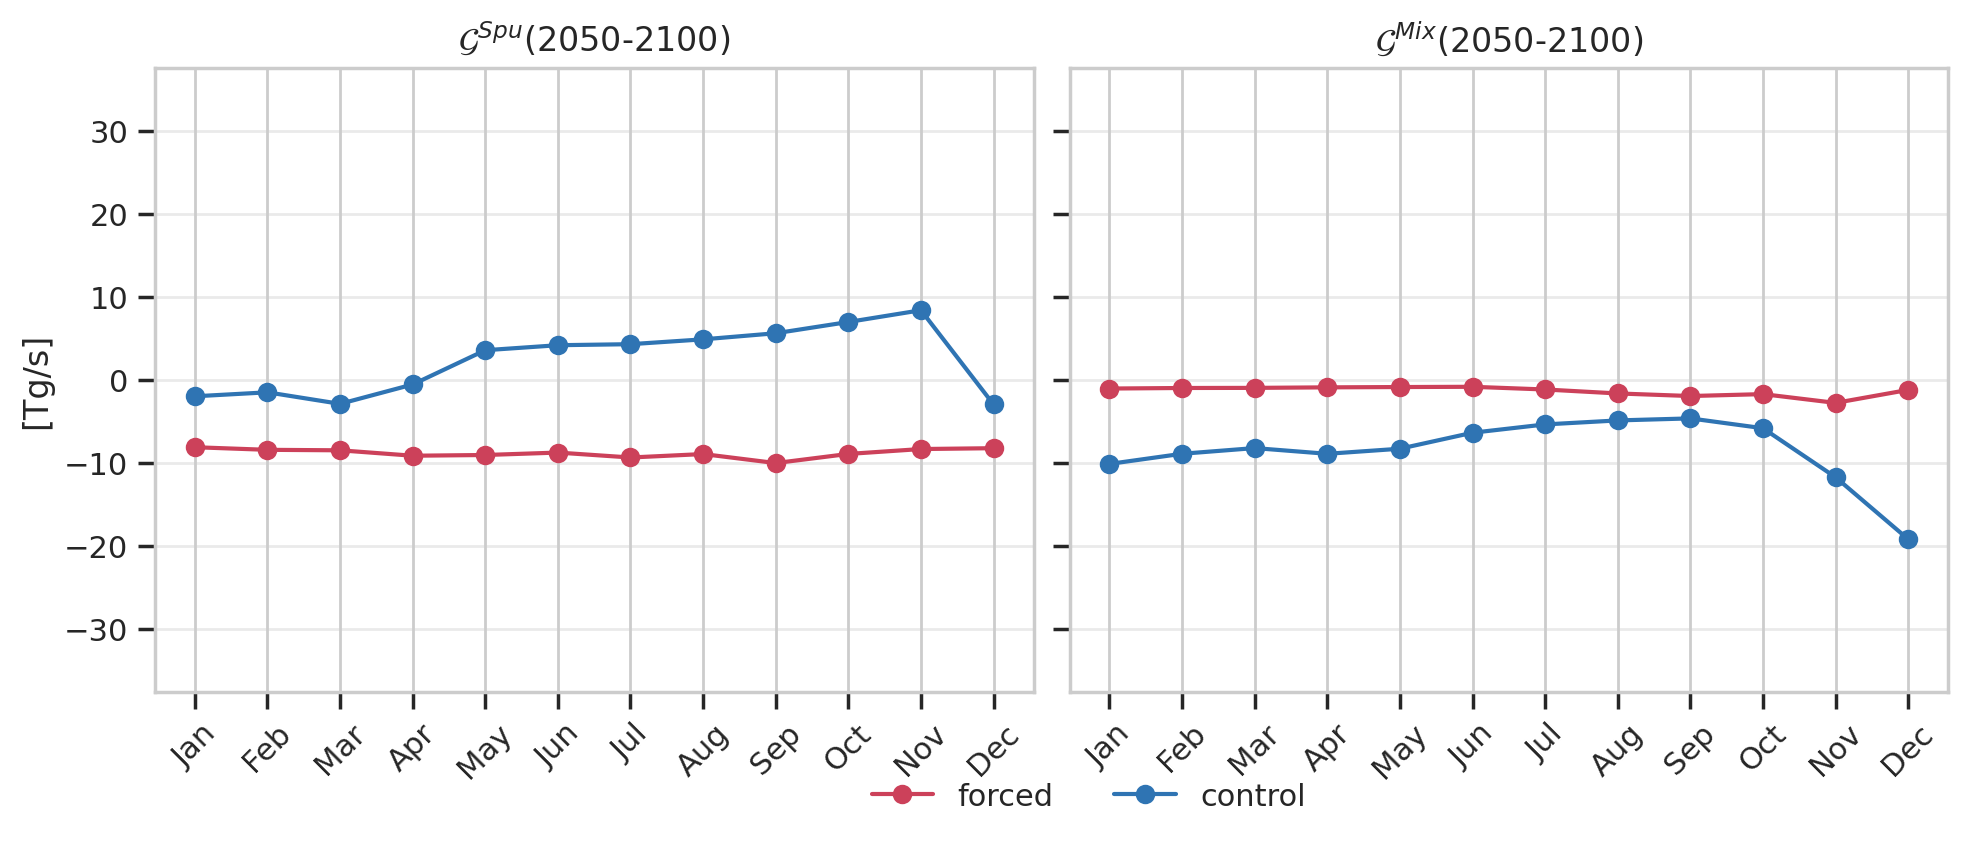

In [13]:
experiments = ['forced', 'control']
nexpt = len(experiments)

fig, ax = plt.subplots(1, 2, figsize = (10, 4), sharey = "row")

width = 0.25
times = ("2050", "2100")

wmt_mean = mass_flux_units_conversion * ds.sel(sigma2_l_target = sigma, method = "nearest")
wmt_mean = wmt_mean.sel(time = slice(times[0], times[1])).groupby("time.month").mean("time")

it = 0
ax[0].set_title(r"$\mathcal{G}^{Spu}$" + '(' + '-'.join(t) + ')')
ax[1].set_title(r"$\mathcal{G}^{Mix}$" + '(' +'-'.join(t) + ')')

max_flux =  np.abs(wmt_mean.sel(exp = "control")["BF_Adv"]).max() + 3

for (i, exp) in enumerate(experiments):
    wmt_mean_budget =  wmt_mean.sel(exp = exp)["spurious_numerical_mixing"]
    ax[0].plot(wmt_mean_budget.month * 1.75, wmt_mean_budget, marker = "o", label = exp, color = expt_colors[exp])
    wmt_mean_budget =  wmt_mean.sel(exp = exp)["diffusion"]
    ax[1].plot(wmt_mean_budget.month * 1.75, wmt_mean_budget, marker = "o", label = exp, color = expt_colors[exp])

ax[0].set_ylabel(f"[{mass_flux_units}]")
fig.tight_layout()

months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
[a.set_xticks(wmt_mean_budget.month * 1.75, months, rotation = 45) for a in ax];
[a.grid(alpha = 0.4, axis = "y") for a in ax.flatten()]

# ax[0].set_ylabel(r"$\mathcal{G}^{BF}_{NonAdv} $" + " [Sv]")
ax[1].legend(ncols = 3, bbox_to_anchor = (0.3, -0.1), frameon = False)
ax[0].set_ylim(-max_flux, max_flux)
[a.tick_params(bottom=True, left=True) for a in ax];
fig.savefig(plotsdir("paper_figures/Gmix_sigma_37.png"), bbox_inches = "tight", dpi = dpi)

### Spatial patterns of advection and tendency terms

In [39]:
ds_sfc = xr.open_dataset(
        datadir("/model/Southern_Ocean_Surface_Advection_and_Tendency_sigma37.nc"))

In [51]:
ds_sfc["surface_ocean_flux_advective_negative_rhs"] = ds_sfc["surface_ocean_flux_advective_negative_rhs_heat"] + ds_sfc["surface_ocean_flux_advective_negative_rhs_salt"]
ds_sfc["BF_Adv"] = ds_sfc["surface_ocean_flux_advective_negative_rhs"]
ds_sfc["BF_NonAdv"] = ds_sfc["boundary_fluxes"] - ds_sfc["BF_Adv"]

ds_sfc["boundary_fluxes_heat"] = ds_sfc["surface_ocean_flux_advective_negative_rhs_heat"] +\
                                 ds_sfc["surface_exchange_flux_heat"] +\
                                 ds_sfc["frazil_ice_heat"] + ds_sfc["bottom_flux_heat"]

ds_sfc["boundary_fluxes_salt"] = ds_sfc["surface_ocean_flux_advective_negative_rhs_salt"] +\
                                 ds_sfc["surface_exchange_flux_salt"]

ds_sfc["diffusion"] = ds_sfc["diffusion_salt"] +  ds_sfc["diffusion_heat"]

ds_sfc["spurious_mixing_psi_ratio"] = ds_sfc["spurious_numerical_mixing"].where((ds_sfc["spurious_numerical_mixing"] != 0.0) / \
                                      ds_sfc["convergent_mass_transport"].where((ds_sfc["convergent_mass_transport"] != 0.0)

SyntaxError: incomplete input (41173696.py, line 15)

In [41]:
mass_flux_units_conversion = toTg / (ds_sfc.areacello / (100e3 **2 )) 

mass_flux_units = r"$Tg/100^2 km^2 / s$"


/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


<xarray.DataArray ()> Size: 8B
array(0.00394925)
Coordinates:
    rho2_l           float64 8B 1.037e+03
    sigma2_l_target  float64 8B 37.0
    exp              <U7 28B 'control'
<xarray.DataArray ()> Size: 8B
array(0.01104515)
Coordinates:
    rho2_l           float64 8B 1.037e+03
    sigma2_l_target  float64 8B 37.0
    exp              <U7 28B 'forced'


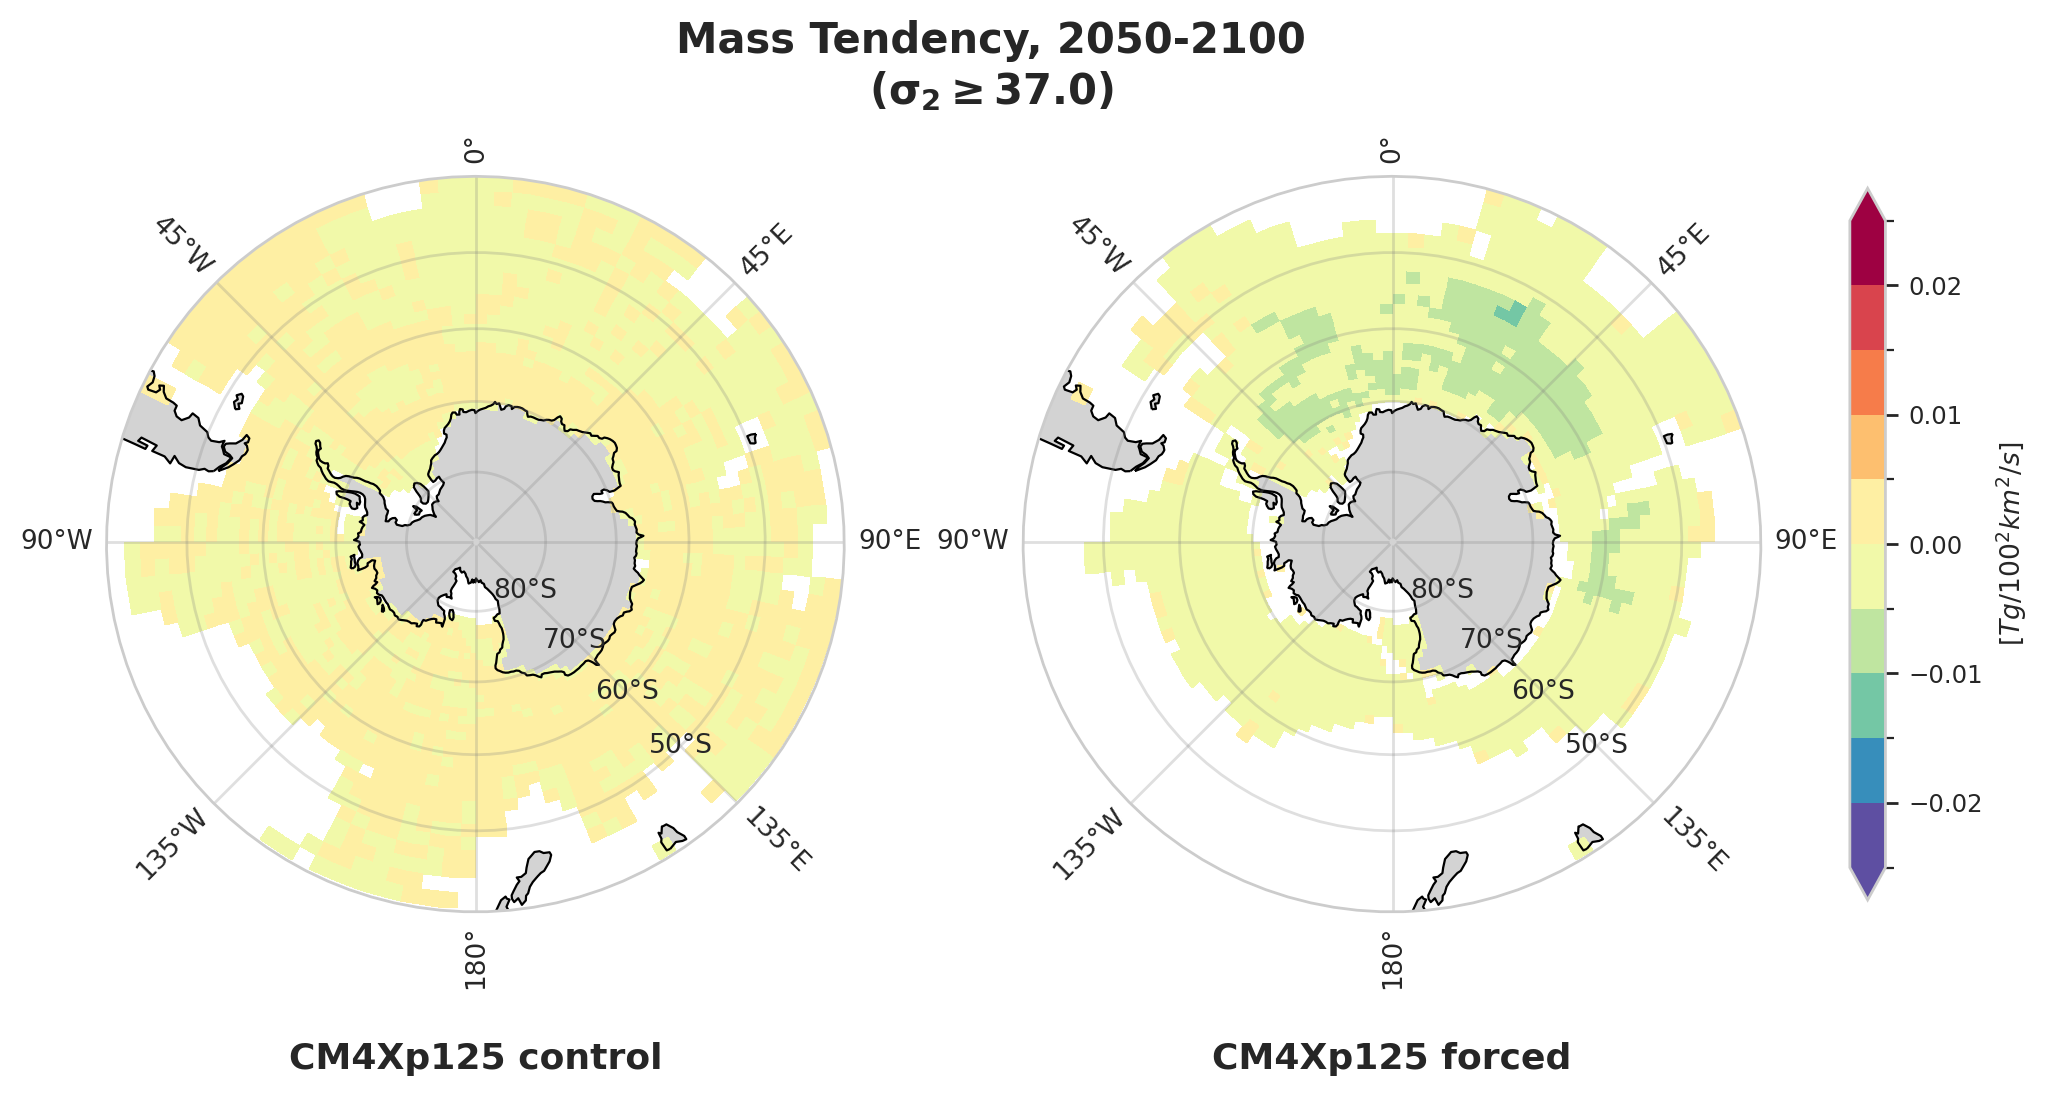

In [42]:
import matplotlib.patches as  mpath
from matplotlib.colors import BoundaryNorm, ListedColormap
import cartopy.feature as cfeature

experiments = ['control', 'forced']
nexpt = len(experiments)
sns.set_style("whitegrid")
sns.set_context("paper")
mpl.rcParams['figure.dpi'] = 200

cmap = plt.get_cmap('Spectral_r')
# boundaries = np.arange(-0.02, 0.0201, 0.005)
# boundaries = np.arange(-0.05, 0.0501, 0.01)
boundaries = np.arange(-0.05, 0.0501, 0.01) / 2

boundaries[np.abs(boundaries) < 1e-16]  = 0
norm = BoundaryNorm(boundaries, ncolors=cmap.N, clip=False)

fig, ax = plt.subplots(1, 2, figsize = (10, 5),
                        subplot_kw={'projection': ccrs.SouthPolarStereo()})
[a.set_extent([-180, 180, -90, -40], ccrs.PlateCarree()) for a in ax.flatten()]
width = 0.25
times = ("2050", "2100")

wmt_mean = ds_sfc.sel(time = slice(times[0], times[1])).mean("time")
curr_width = 0.0
for (i, exp) in enumerate(experiments):

    wmt_mean_budget =  mass_flux_units_conversion * wmt_mean.sel(exp = exp)["mass_tendency"]
    wmt_mean_budget = wmt_mean_budget.where(wmt_mean_budget != 0.0)
    print(np.max(np.abs(wmt_mean_budget)))
    cm = ax[i].pcolormesh(wmt_mean_budget.geolon, wmt_mean_budget.geolat, 
                         wmt_mean_budget, cmap = cmap, transform=ccrs.PlateCarree(), 
                        norm = norm)
    ax[i].coastlines();
    ax[i].add_feature(cfeature.LAND, facecolor='lightgrey')

    # Draw meridian lines with labels around circular boundary
    gls = ax[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, \
                    xlocs=range(-180,171,45), ylocs=range(-90,0,10), \
                    color='gray', alpha=0.25, linestyle='-', zorder=10, 
                    xlabel_style = {"fontsize":9.5})
    
    # # Draw concentric circles (but hide labels) for the parallels of the latitude
    # ax[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=1, \
    #                 xlocs=[], ylocs=range(-90,0,10), \
    #                 color='gray', alpha=0.25, linestyle='--', zorder=10)
    # Add circular boundary
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    
    ax[i].set_boundary(circle, transform=ax[i].transAxes)
        
fig.suptitle("Mass Tendency, " + '-'.join(times) + "\n" + r"$\mathbf{(\sigma_2 \geq 37.0)}$", 
             fontweight = "bold", fontsize = 15, ha='center')


fig.tight_layout()

for a, row in zip(ax, experiments):
    a.annotate("CM4Xp125 " + row, xy=(0.5, -0.2), xytext=(-0, 0),
                xycoords='axes fraction', textcoords='offset points',
                fontsize=13, ha='center', va='center', fontweight = "bold")
    
fig.colorbar(cm, ax = ax[:], label = f"[{mass_flux_units}]", fraction = 0.02, extend = "both")

fig.savefig(plotsdir("paper_figures/dMdt_sigma_37_surface.png"), bbox_inches = "tight", dpi = dpi)

/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


<xarray.DataArray ()> Size: 8B
array(0.13878879)
Coordinates:
    rho2_l           float64 8B 1.037e+03
    sigma2_l_target  float64 8B 37.0
    exp              <U7 28B 'control'
<xarray.DataArray ()> Size: 8B
array(0.03555562)
Coordinates:
    rho2_l           float64 8B 1.037e+03
    sigma2_l_target  float64 8B 37.0
    exp              <U7 28B 'forced'


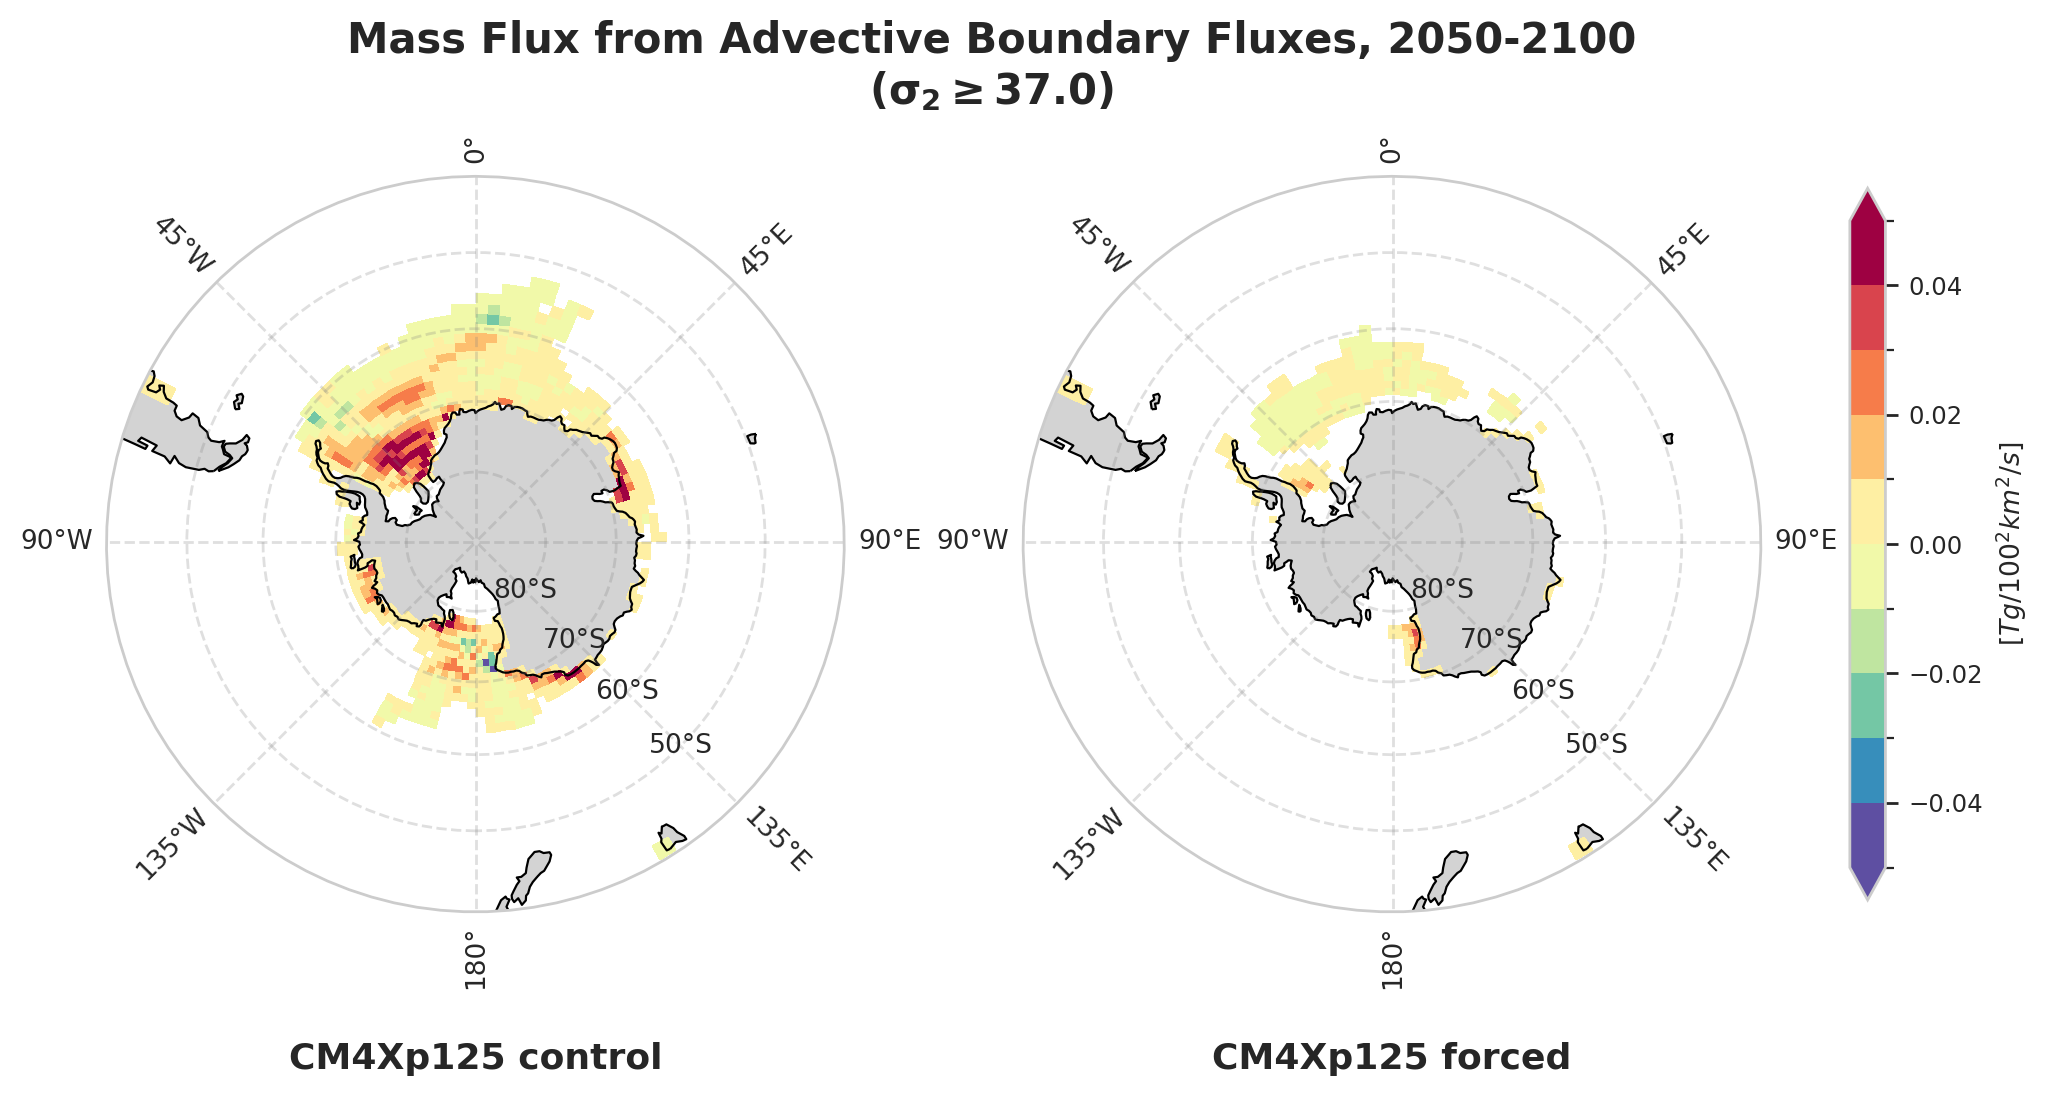

In [43]:
cmap = plt.get_cmap('Spectral_r')
boundaries = np.arange(-0.05, 0.0501, 0.01) 
boundaries[np.abs(boundaries) < 1e-16]  = 0
norm = BoundaryNorm(boundaries, ncolors=cmap.N, clip=False)

fig, ax = plt.subplots(1, 2, figsize = (10, 5),
                        subplot_kw={'projection': ccrs.SouthPolarStereo()})
[a.set_extent([-180, 180, -90, -40], ccrs.PlateCarree()) for a in ax.flatten()]
width = 0.25
times = ("2050", "2100")

wmt_mean = ds_sfc.sel(time = slice(times[0], times[1])).mean("time")
curr_width = 0.0
for (i, exp) in enumerate(experiments):

    wmt_mean_budget =  mass_flux_units_conversion * wmt_mean.sel(exp = exp)["surface_ocean_flux_advective_negative_rhs"]
    wmt_mean_budget = wmt_mean_budget.where(wmt_mean_budget != 0.0)
    print(np.max(np.abs(wmt_mean_budget)))
    cm = ax[i].pcolormesh(wmt_mean_budget.geolon, wmt_mean_budget.geolat, 
                         wmt_mean_budget, cmap = cmap, norm = norm, 
                          transform=ccrs.PlateCarree())
    ax[i].coastlines();
    ax[i].add_feature(cfeature.LAND, facecolor='lightgrey')

    # Draw meridian lines with labels around circular boundary
    ax[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, \
                    xlocs=range(-180,171,45), ylocs=range(-90,0,10), \
                    color='gray', alpha=0.25, linestyle='--', zorder=10, 
                    xlabel_style = {"fontsize":9.5})
    
    # Add circular boundary
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    
    ax[i].set_boundary(circle, transform=ax[i].transAxes)

fig.suptitle("Mass Flux from Advective Boundary Fluxes, " + '-'.join(times) + "\n" + r"$\mathbf{(\sigma_2 \geq 37.0)}$", 
             fontweight = "bold", fontsize = 15)

fig.tight_layout()

for a, row in zip(ax, experiments):
    a.annotate("CM4Xp125 " + row, xy=(0.5, -0.2), xytext=(-0, 0),
                xycoords='axes fraction', textcoords='offset points',
                fontsize=13, ha='center', va='center', fontweight = "bold")
    
fig.colorbar(cm, ax = ax[:], label = f"[{mass_flux_units}]", fraction = 0.02, extend = "both")

fig.savefig(plotsdir("paper_figures/Gadv_sigma_37_surface.png"), bbox_inches = "tight", dpi = dpi)

/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


<xarray.DataArray ()> Size: 8B
array(0.11542549)
Coordinates:
    rho2_l           float64 8B 1.037e+03
    sigma2_l_target  float64 8B 37.0
    exp              <U7 28B 'control'
<xarray.DataArray ()> Size: 8B
array(0.02707589)
Coordinates:
    rho2_l           float64 8B 1.037e+03
    sigma2_l_target  float64 8B 37.0
    exp              <U7 28B 'forced'


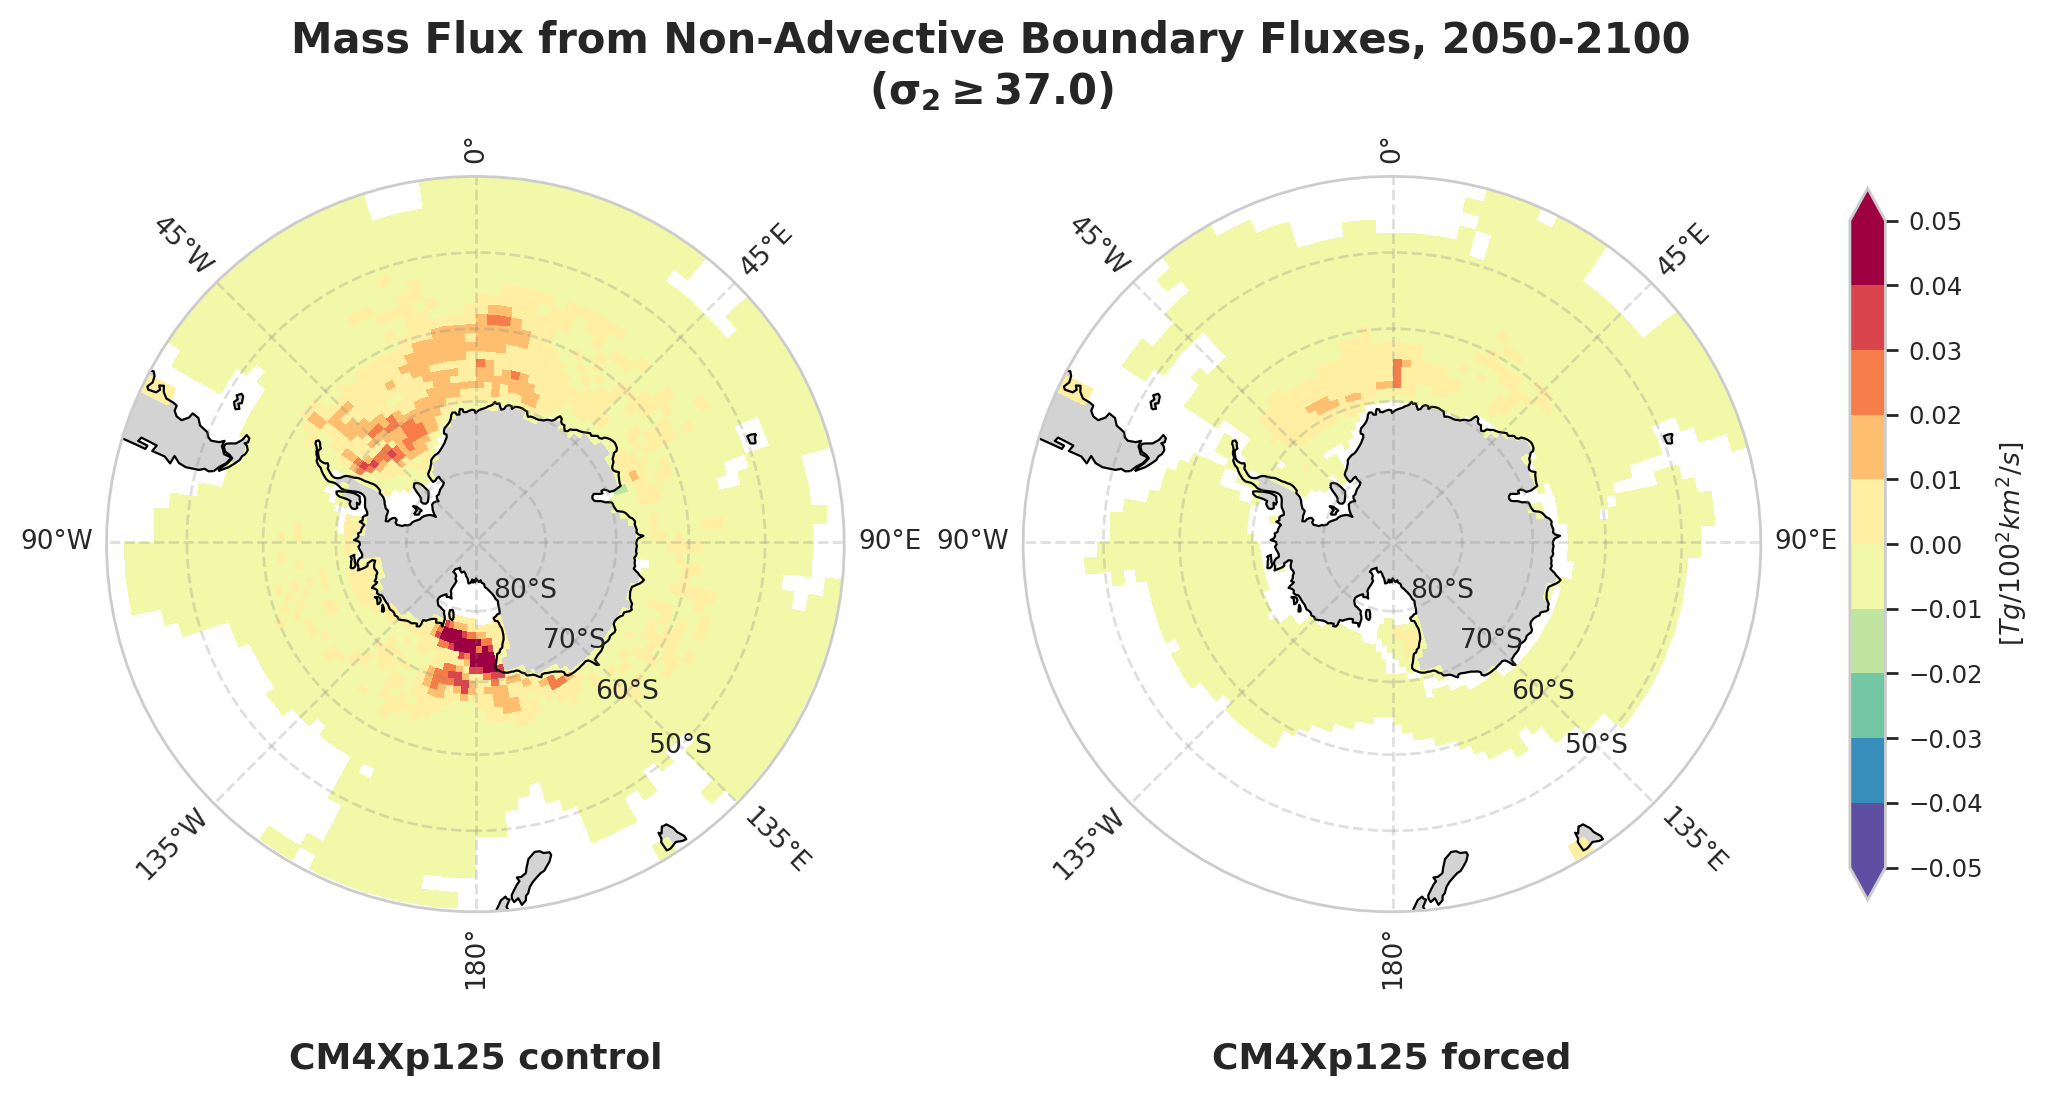

In [44]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5),
                        subplot_kw={'projection': ccrs.SouthPolarStereo()})
[a.set_extent([-180, 180, -90, -40], ccrs.PlateCarree()) for a in ax.flatten()]
width = 0.25
times = ("2050", "2100")

wmt_mean = ds_sfc.sel(time = slice(times[0], times[1])).mean("time")
curr_width = 0.0
for (i, exp) in enumerate(experiments):

    wmt_mean_budget =  mass_flux_units_conversion * wmt_mean.sel(exp = exp)["BF_NonAdv"]
    wmt_mean_budget = wmt_mean_budget.where(wmt_mean_budget != 0.0)
    print(np.max(np.abs(wmt_mean_budget)))
    cm = ax[i].pcolormesh(wmt_mean_budget.geolon, wmt_mean_budget.geolat, 
                         wmt_mean_budget, cmap = cmap, norm = norm, 
                          transform=ccrs.PlateCarree())
    ax[i].coastlines();
    ax[i].add_feature(cfeature.LAND, facecolor='lightgrey')

    # Draw meridian lines with labels around circular boundary
    ax[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, \
                    xlocs=range(-180,171,45), ylocs=range(-90,0,10), \
                    color='gray', alpha=0.25, linestyle='--', zorder=10, 
                    xlabel_style = {"fontsize":9.5})
    # Add circular boundary
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    
    ax[i].set_boundary(circle, transform=ax[i].transAxes)

fig.suptitle("Mass Flux from Non-Advective Boundary Fluxes, " + '-'.join(times) + "\n" + r"$\mathbf{(\sigma_2 \geq 37.0)}$", 
             fontweight = "bold", fontsize = 15)


fig.tight_layout()

for a, row in zip(ax, experiments):
    a.annotate("CM4Xp125 " + row, xy=(0.5, -0.2), xytext=(-0, 0),
                xycoords='axes fraction', textcoords='offset points',
                fontsize=13, ha='center', va='center', fontweight = "bold")
    
fig.colorbar(cm, ax = ax[:], label = f"[{mass_flux_units}]", fraction = 0.02, extend = "both", ticks=boundaries)

fig.savefig(plotsdir("paper_figures/Gnadv_sigma_37_surface.png"), bbox_inches = "tight", dpi = dpi)

/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


<xarray.DataArray ()> Size: 8B
array(0.10955638)
Coordinates:
    rho2_l           float64 8B 1.037e+03
    sigma2_l_target  float64 8B 37.0
    exp              <U7 28B 'control'
<xarray.DataArray ()> Size: 8B
array(0.02795833)
Coordinates:
    rho2_l           float64 8B 1.037e+03
    sigma2_l_target  float64 8B 37.0
    exp              <U7 28B 'forced'


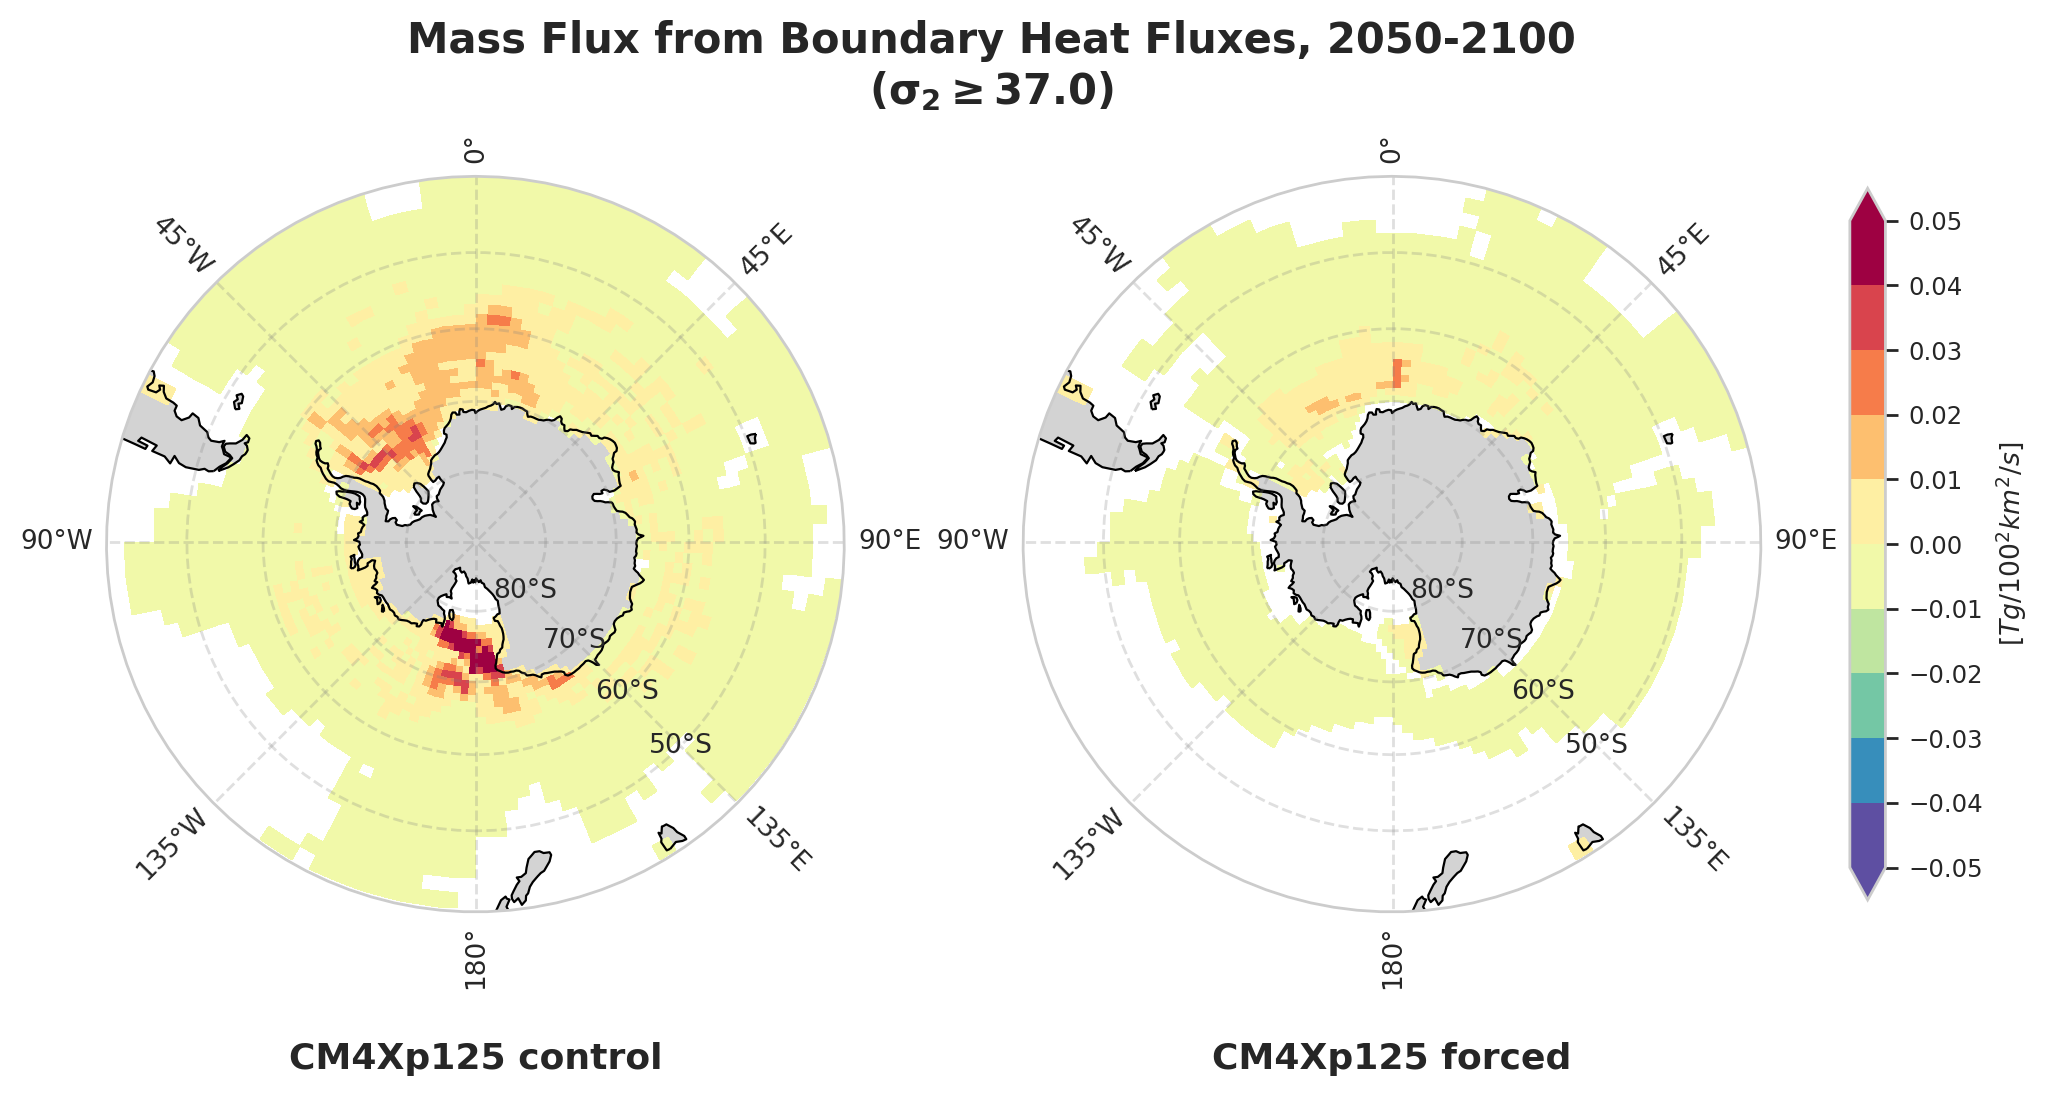

In [45]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5),
                        subplot_kw={'projection': ccrs.SouthPolarStereo()})
[a.set_extent([-180, 180, -90, -40], ccrs.PlateCarree()) for a in ax.flatten()]
width = 0.25
times = ("2050", "2100")

wmt_mean = ds_sfc.sel(time = slice(times[0], times[1])).mean("time")
curr_width = 0.0
for (i, exp) in enumerate(experiments):

    wmt_mean_budget =  mass_flux_units_conversion * wmt_mean.sel(exp = exp)["boundary_fluxes_heat"]
    wmt_mean_budget = wmt_mean_budget.where(wmt_mean_budget != 0.0)
    print(np.max(np.abs(wmt_mean_budget)))
    cm = ax[i].pcolormesh(wmt_mean_budget.geolon, wmt_mean_budget.geolat, 
                         wmt_mean_budget, cmap = cmap, norm = norm, 
                          transform=ccrs.PlateCarree())
    ax[i].coastlines();
    ax[i].add_feature(cfeature.LAND, facecolor='lightgrey')

    # Draw meridian lines with labels around circular boundary
    ax[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, \
                    xlocs=range(-180,171,45), ylocs=range(-90,0,10), \
                    color='gray', alpha=0.25, linestyle='--', zorder=10, 
                    xlabel_style = {"fontsize":9.5})
    # Add circular boundary
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    
    ax[i].set_boundary(circle, transform=ax[i].transAxes)

fig.suptitle("Mass Flux from Boundary Heat Fluxes, " + '-'.join(times) + "\n" + r"$\mathbf{(\sigma_2 \geq 37.0)}$", 
             fontweight = "bold", fontsize = 15)


fig.tight_layout()

for a, row in zip(ax, experiments):
    a.annotate("CM4Xp125 " + row, xy=(0.5, -0.2), xytext=(-0, 0),
                xycoords='axes fraction', textcoords='offset points',
                fontsize=13, ha='center', va='center', fontweight = "bold")
    
fig.colorbar(cm, ax = ax[:], label = f"[{mass_flux_units}]", fraction = 0.02, extend = "both", ticks=boundaries)

fig.savefig(plotsdir("paper_figures/GBFheat_sigma_37_surface.png"), bbox_inches = "tight", dpi = dpi)

/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


<xarray.DataArray ()> Size: 8B
array(0.12355337)
Coordinates:
    rho2_l           float64 8B 1.037e+03
    sigma2_l_target  float64 8B 37.0
    exp              <U7 28B 'control'
<xarray.DataArray ()> Size: 8B
array(0.03183072)
Coordinates:
    rho2_l           float64 8B 1.037e+03
    sigma2_l_target  float64 8B 37.0
    exp              <U7 28B 'forced'


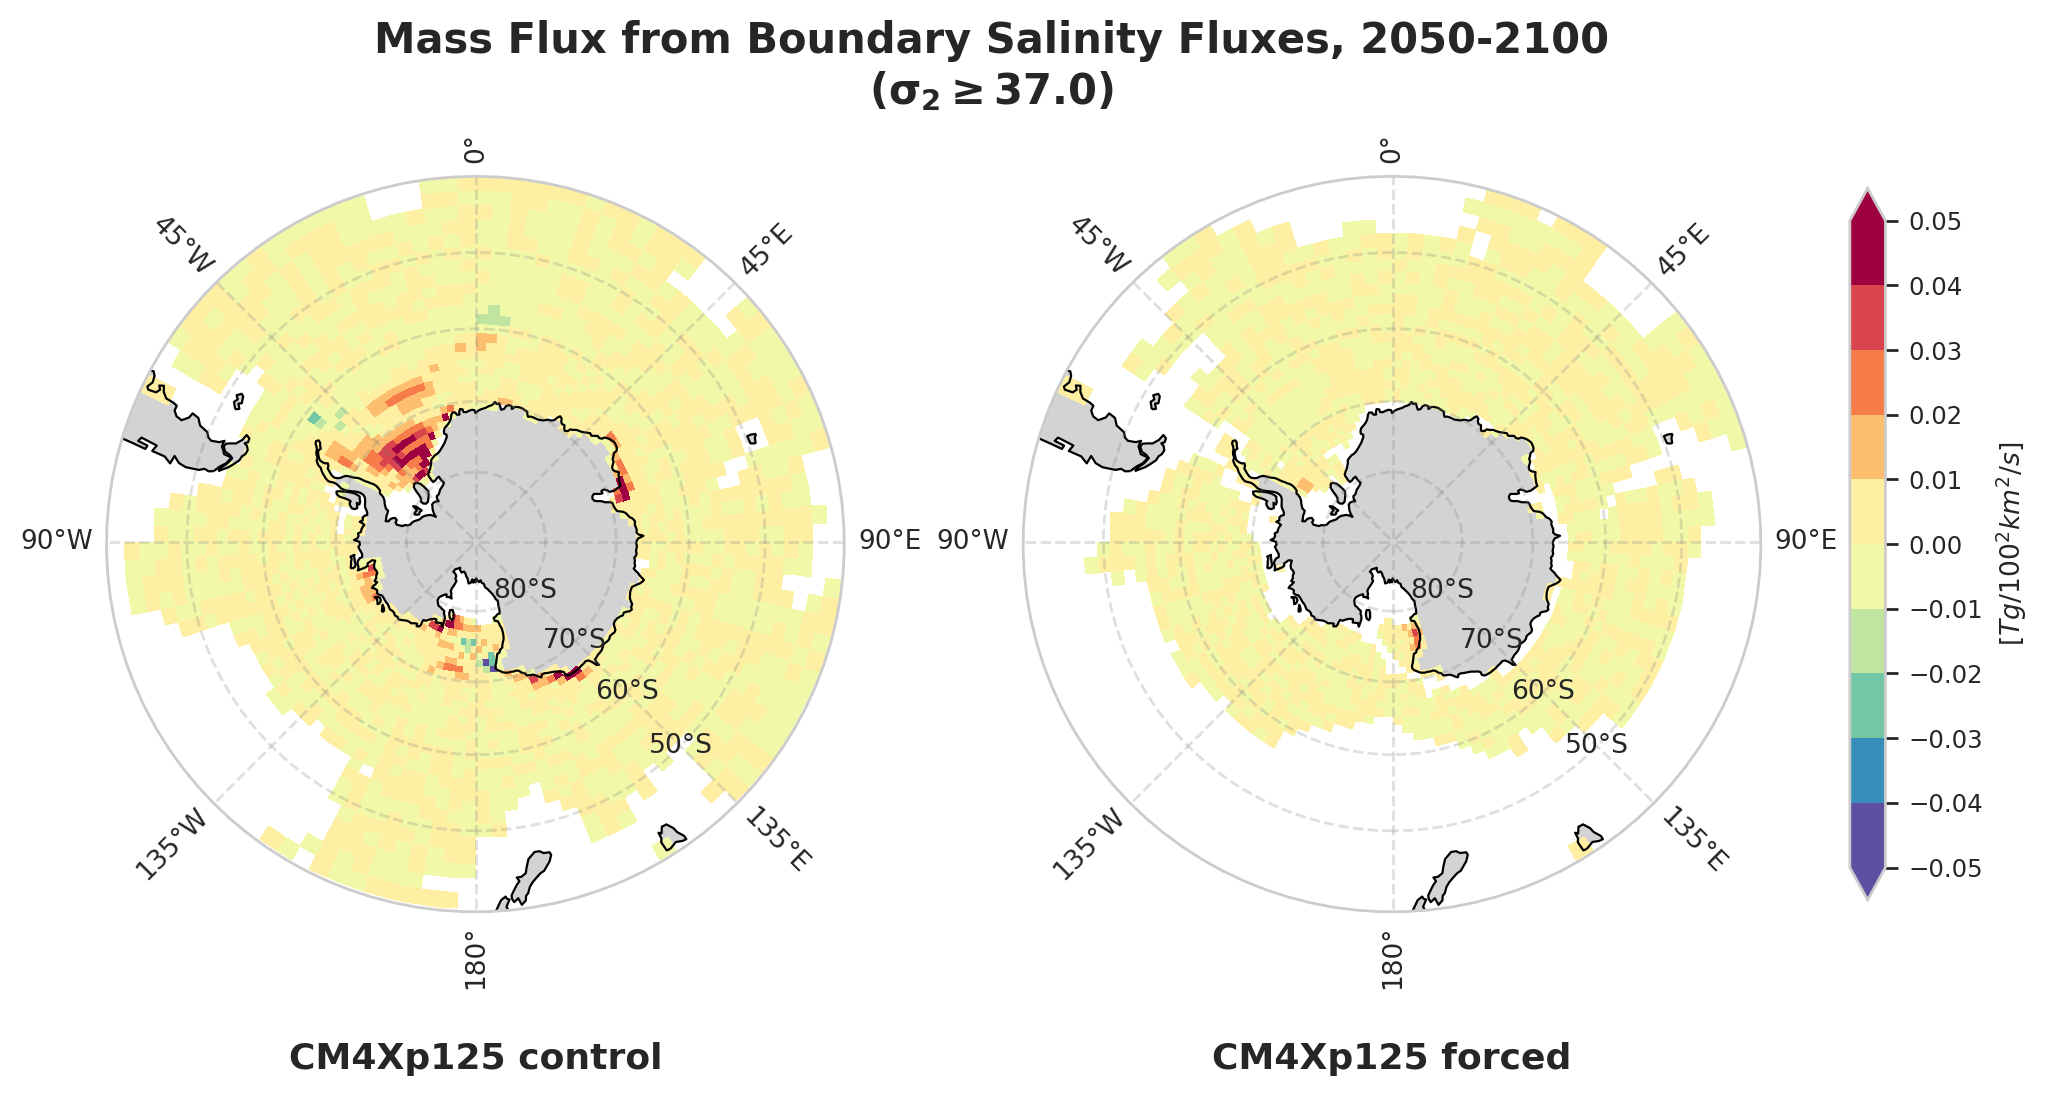

In [46]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5),
                        subplot_kw={'projection': ccrs.SouthPolarStereo()})
[a.set_extent([-180, 180, -90, -40], ccrs.PlateCarree()) for a in ax.flatten()]
width = 0.25
times = ("2050", "2100")

wmt_mean = ds_sfc.sel(time = slice(times[0], times[1])).mean("time")
curr_width = 0.0
for (i, exp) in enumerate(experiments):

    wmt_mean_budget =  mass_flux_units_conversion * wmt_mean.sel(exp = exp)["boundary_fluxes_salt"]
    wmt_mean_budget = wmt_mean_budget.where(wmt_mean_budget != 0.0)
    print(np.max(np.abs(wmt_mean_budget)))
    cm = ax[i].pcolormesh(wmt_mean_budget.geolon, wmt_mean_budget.geolat, 
                         wmt_mean_budget, cmap = cmap, norm = norm, 
                          transform=ccrs.PlateCarree())
    ax[i].coastlines();
    ax[i].add_feature(cfeature.LAND, facecolor='lightgrey')

    # Draw meridian lines with labels around circular boundary
    ax[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, \
                    xlocs=range(-180,171,45), ylocs=range(-90,0,10), \
                    color='gray', alpha=0.25, linestyle='--', zorder=10, 
                    xlabel_style = {"fontsize":9.5})
    # Add circular boundary
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    
    ax[i].set_boundary(circle, transform=ax[i].transAxes)

fig.suptitle("Mass Flux from Boundary Salinity Fluxes, " + '-'.join(times) + "\n" + r"$\mathbf{(\sigma_2 \geq 37.0)}$", 
             fontweight = "bold", fontsize = 15)


fig.tight_layout()

for a, row in zip(ax, experiments):
    a.annotate("CM4Xp125 " + row, xy=(0.5, -0.2), xytext=(-0, 0),
                xycoords='axes fraction', textcoords='offset points',
                fontsize=13, ha='center', va='center', fontweight = "bold")
    
fig.colorbar(cm, ax = ax[:], label = f"[{mass_flux_units}]", fraction = 0.02, extend = "both", ticks=boundaries)

fig.savefig(plotsdir("paper_figures/GBFsalt_sigma_37_surface.png"), bbox_inches = "tight", dpi = dpi)

/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


<xarray.DataArray ()> Size: 8B
array(0.10704192)
Coordinates:
    rho2_l           float64 8B 1.037e+03
    sigma2_l_target  float64 8B 37.0
    exp              <U7 28B 'control'
<xarray.DataArray ()> Size: 8B
array(0.01530432)
Coordinates:
    rho2_l           float64 8B 1.037e+03
    sigma2_l_target  float64 8B 37.0
    exp              <U7 28B 'forced'


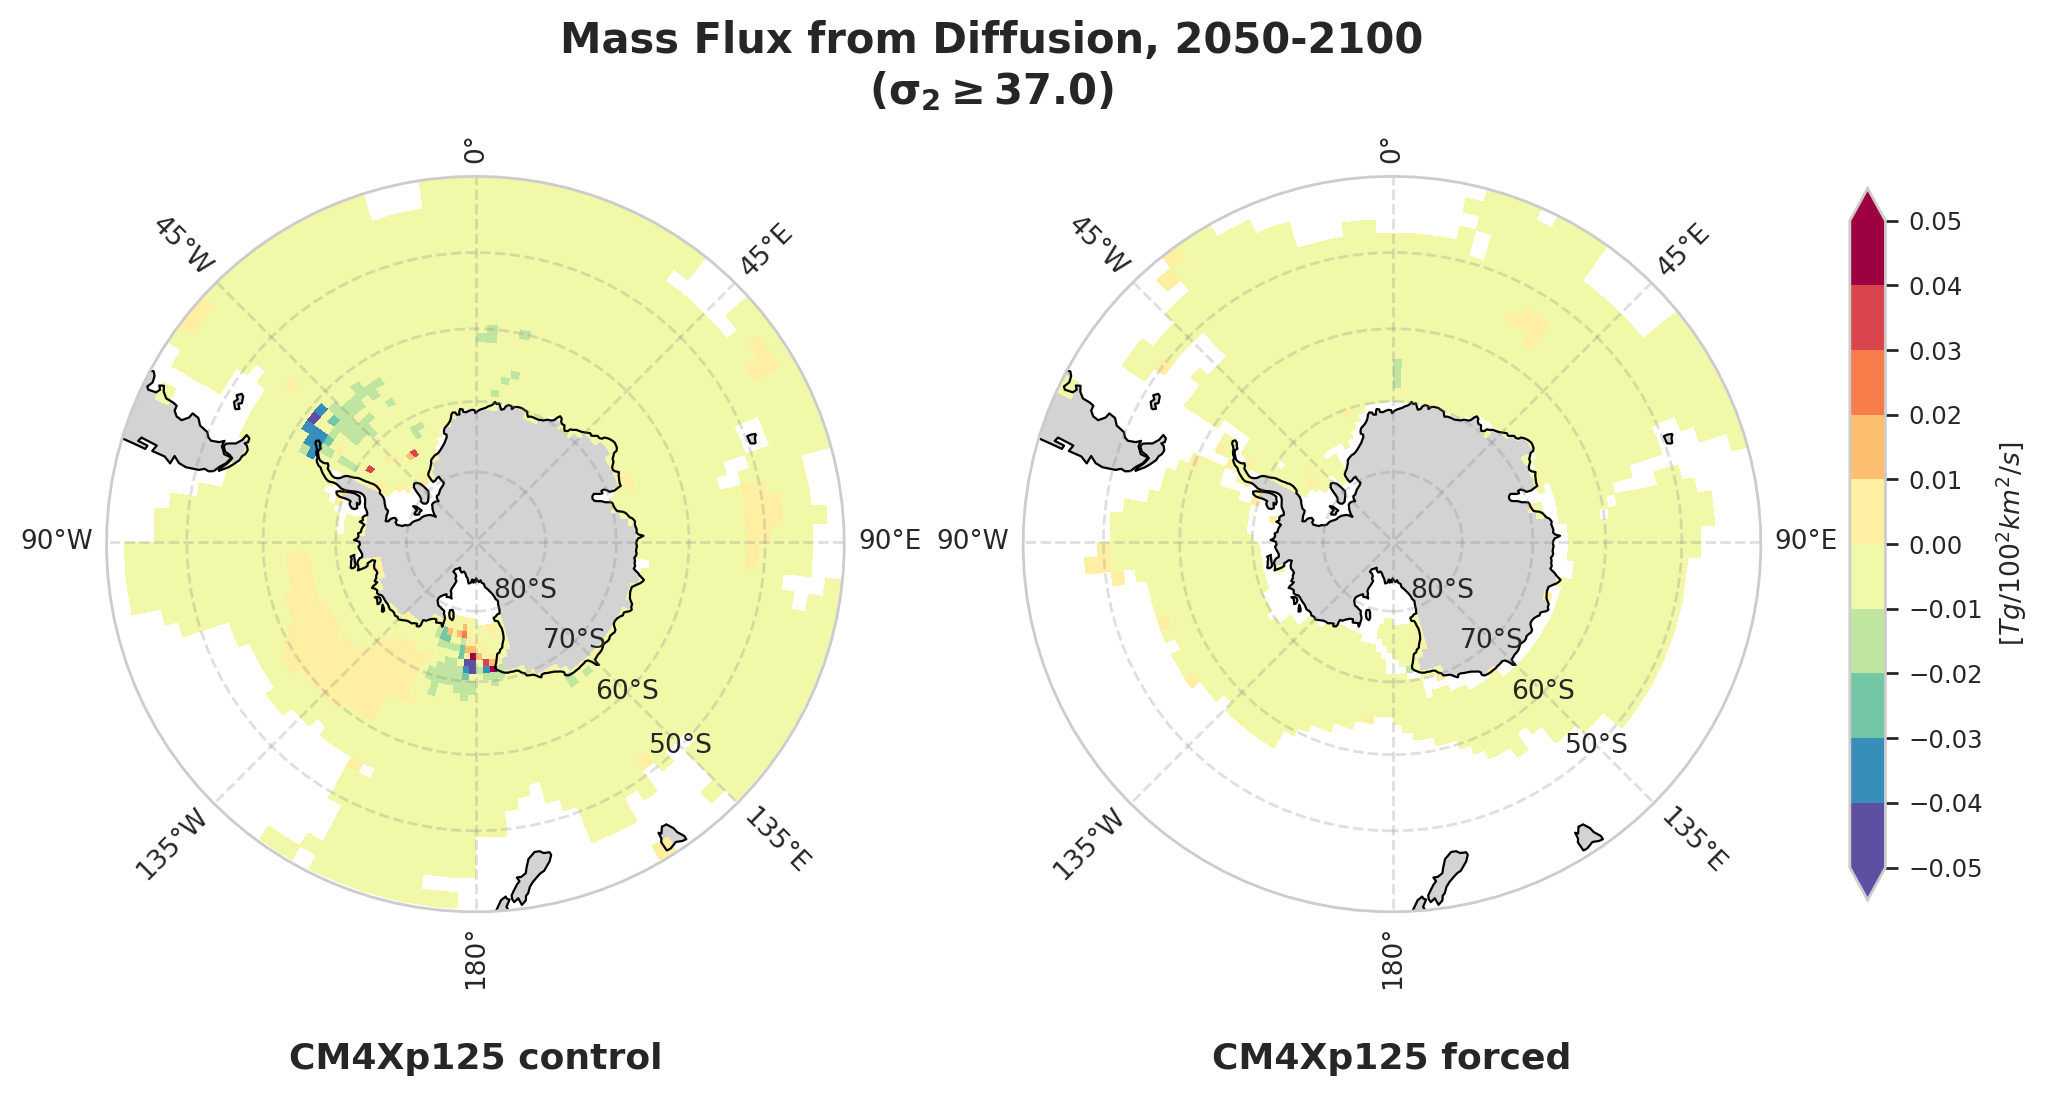

In [47]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5),
                        subplot_kw={'projection': ccrs.SouthPolarStereo()})
[a.set_extent([-180, 180, -90, -40], ccrs.PlateCarree()) for a in ax.flatten()]
width = 0.25
times = ("2050", "2100")

experiments = ['control', 'forced']
cmap = plt.get_cmap('Spectral_r')
boundaries = np.arange(-0.05, 0.0501, 0.01)
boundaries[np.abs(boundaries) < 1e-16]  = 0
norm = BoundaryNorm(boundaries, ncolors=cmap.N, clip=False)

wmt_mean = ds_sfc.sel(time = slice(times[0], times[1])).mean("time")
curr_width = 0.0
for (i, exp) in enumerate(experiments):

    wmt_mean_budget =  mass_flux_units_conversion * wmt_mean.sel(exp = exp)["diffusion"]
    wmt_mean_budget = wmt_mean_budget.where(wmt_mean_budget != 0.0)
    print(np.max(np.abs(wmt_mean_budget)))
    cm = ax[i].pcolormesh(wmt_mean_budget.geolon, wmt_mean_budget.geolat, 
                         wmt_mean_budget, cmap = cmap, norm = norm, 
                          transform=ccrs.PlateCarree())
    ax[i].coastlines();
    ax[i].add_feature(cfeature.LAND, facecolor='lightgrey')

    # Draw meridian lines with labels around circular boundary
    ax[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, \
                    xlocs=range(-180,171,45), ylocs=range(-90,0,10), \
                    color='gray', alpha=0.25, linestyle='--', zorder=10, 
                    xlabel_style = {"fontsize":9.5})
    # Add circular boundary
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    
    ax[i].set_boundary(circle, transform=ax[i].transAxes)

fig.suptitle("Mass Flux from Diffusion, " + '-'.join(times) + "\n" + r"$\mathbf{(\sigma_2 \geq 37.0)}$", 
             fontweight = "bold", fontsize = 15)
fig.tight_layout()

for a, row in zip(ax, experiments):
    a.annotate("CM4Xp125 " + row, xy=(0.5, -0.2), xytext=(-0, 0),
                xycoords='axes fraction', textcoords='offset points',
                fontsize=13, ha='center', va='center', fontweight = "bold")
    
fig.colorbar(cm, ax = ax[:], label = f"[{mass_flux_units}]", fraction = 0.02, extend = "both", ticks=boundaries)

fig.savefig(plotsdir("paper_figures/Gmix_sigma_37_surface.png"), bbox_inches = "tight", dpi = dpi)

/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


<xarray.DataArray ()> Size: 8B
array(1.94627002)
Coordinates:
    rho2_l           float64 8B 1.037e+03
    sigma2_l_target  float64 8B 37.0
    exp              <U7 28B 'control'
<xarray.DataArray ()> Size: 8B
array(0.18308751)
Coordinates:
    rho2_l           float64 8B 1.037e+03
    sigma2_l_target  float64 8B 37.0
    exp              <U7 28B 'forced'


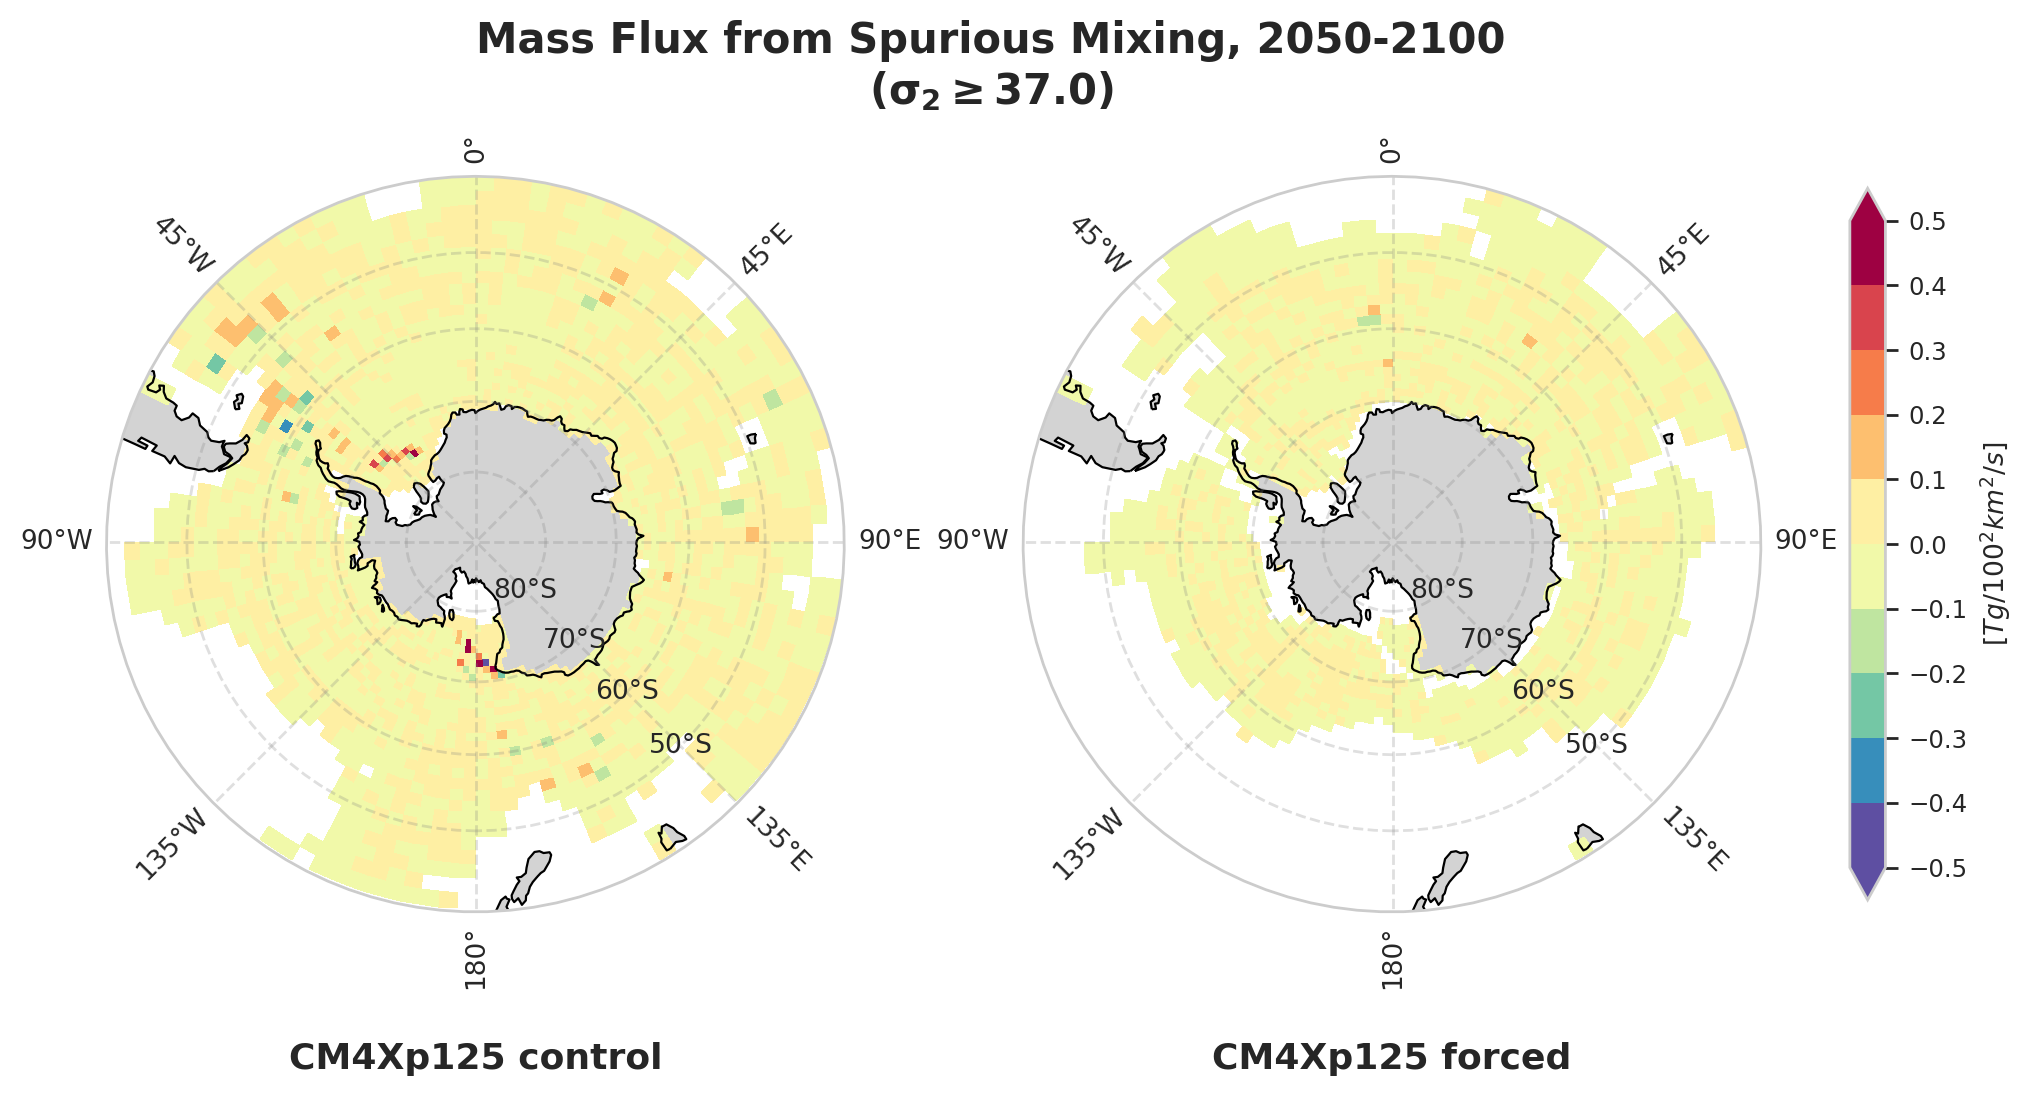

In [48]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5),
                        subplot_kw={'projection': ccrs.SouthPolarStereo()})
[a.set_extent([-180, 180, -90, -40], ccrs.PlateCarree()) for a in ax.flatten()]
width = 0.25
times = ("2050", "2100")

experiments = ['control', 'forced']
cmap = plt.get_cmap('Spectral_r')
boundaries = np.arange(-0.5, 0.501, 0.1)
boundaries[np.abs(boundaries) < 1e-16]  = 0

# boundaries = boundaries /2 
norm = BoundaryNorm(boundaries, ncolors=cmap.N, clip=False)

wmt_mean = ds_sfc.sel(time = slice(times[0], times[1])).mean("time")
curr_width = 0.0
for (i, exp) in enumerate(experiments):

    wmt_mean_budget =  mass_flux_units_conversion * wmt_mean.sel(exp = exp)["spurious_numerical_mixing"]
    wmt_mean_budget = wmt_mean_budget.where(wmt_mean_budget != 0.0)
    print(np.max(np.abs(wmt_mean_budget)))
    cm = ax[i].pcolormesh(wmt_mean_budget.geolon, wmt_mean_budget.geolat, 
                         wmt_mean_budget, cmap = cmap, norm = norm, 
                          transform=ccrs.PlateCarree())
    ax[i].coastlines();
    ax[i].add_feature(cfeature.LAND, facecolor='lightgrey')

    # Draw meridian lines with labels around circular boundary
    ax[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, \
                    xlocs=range(-180,171,45), ylocs=range(-90,0,10), \
                    color='gray', alpha=0.25, linestyle='--', zorder=10, 
                    xlabel_style = {"fontsize":9.5})
    # Add circular boundary
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    
    ax[i].set_boundary(circle, transform=ax[i].transAxes)

fig.suptitle("Mass Flux from Spurious Mixing, " + '-'.join(times) + "\n" + r"$\mathbf{(\sigma_2 \geq 37.0)}$", 
             fontweight = "bold", fontsize = 15)


fig.tight_layout()

for a, row in zip(ax, experiments):
    a.annotate("CM4Xp125 " + row, xy=(0.5, -0.2), xytext=(-0, 0),
                xycoords='axes fraction', textcoords='offset points',
                fontsize=13, ha='center', va='center', fontweight = "bold")
    
fig.colorbar(cm, ax = ax[:], label = f"[{mass_flux_units}]", fraction = 0.02, extend = "both", ticks=boundaries)

fig.savefig(plotsdir("paper_figures/Gspur_sigma_37_surface.png"), bbox_inches = "tight", dpi = dpi)

/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


<xarray.DataArray ()> Size: 8B
array(2.07988691)
Coordinates:
    rho2_l           float64 8B 1.037e+03
    sigma2_l_target  float64 8B 37.0
    exp              <U7 28B 'control'
<xarray.DataArray ()> Size: 8B
array(0.18508239)
Coordinates:
    rho2_l           float64 8B 1.037e+03
    sigma2_l_target  float64 8B 37.0
    exp              <U7 28B 'forced'


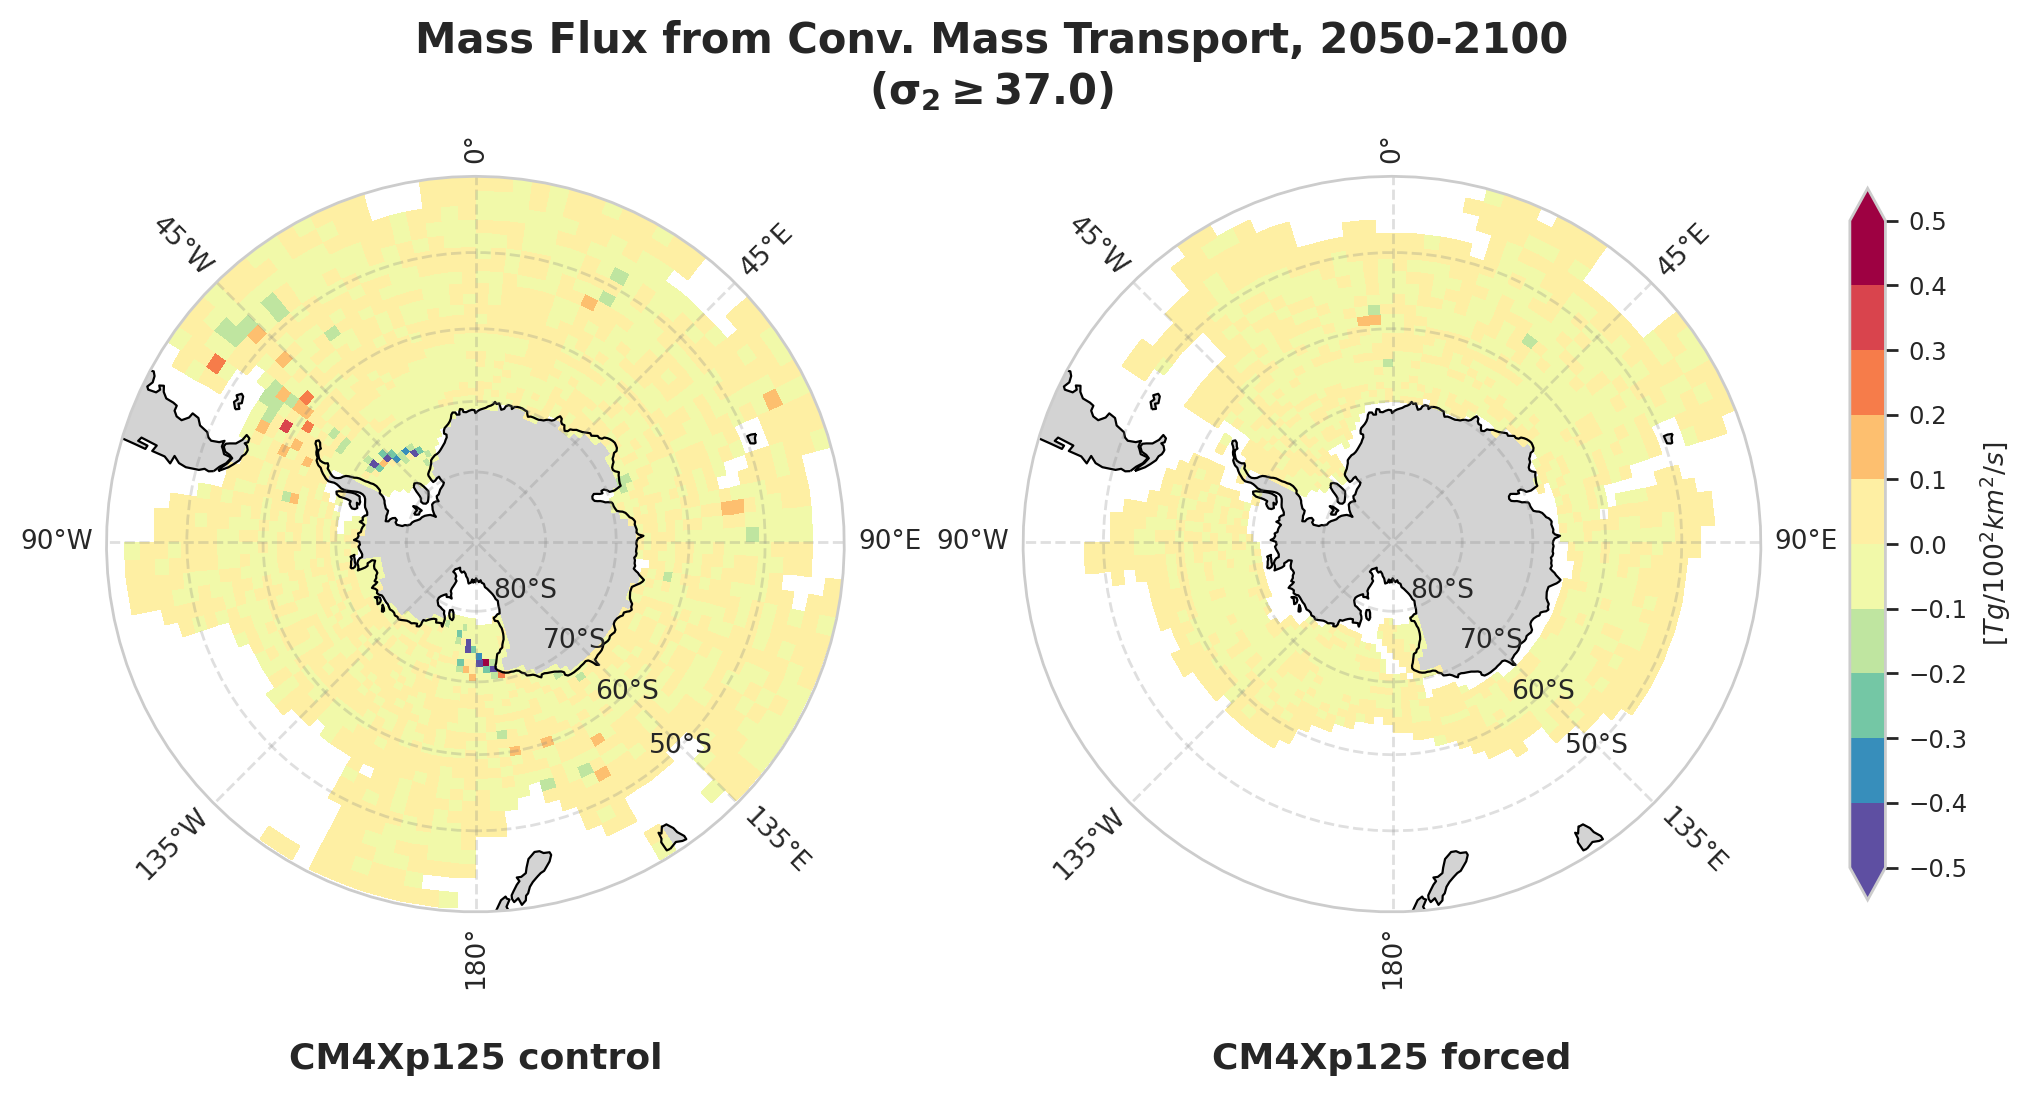

In [49]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5),
                        subplot_kw={'projection': ccrs.SouthPolarStereo()})
[a.set_extent([-180, 180, -90, -40], ccrs.PlateCarree()) for a in ax.flatten()]
width = 0.25
times = ("2050", "2100")

experiments = ['control', 'forced']
cmap = plt.get_cmap('Spectral_r')
boundaries = np.arange(-0.5, 0.501, 0.1)
boundaries[np.abs(boundaries) < 1e-16]  = 0

# boundaries = boundaries /2 
norm = BoundaryNorm(boundaries, ncolors=cmap.N, clip=False)

wmt_mean = ds_sfc.sel(time = slice(times[0], times[1])).mean("time")
curr_width = 0.0
for (i, exp) in enumerate(experiments):

    wmt_mean_budget =  mass_flux_units_conversion * wmt_mean.sel(exp = exp)["convergent_mass_transport"]
    wmt_mean_budget = wmt_mean_budget.where(wmt_mean_budget != 0.0)
    print(np.max(np.abs(wmt_mean_budget)))
    cm = ax[i].pcolormesh(wmt_mean_budget.geolon, wmt_mean_budget.geolat, 
                         wmt_mean_budget, cmap = cmap, norm = norm, 
                          transform=ccrs.PlateCarree())
    ax[i].coastlines();
    ax[i].add_feature(cfeature.LAND, facecolor='lightgrey')

    # Draw meridian lines with labels around circular boundary
    ax[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, \
                    xlocs=range(-180,171,45), ylocs=range(-90,0,10), \
                    color='gray', alpha=0.25, linestyle='--', zorder=10, 
                    xlabel_style = {"fontsize":9.5})
    # Add circular boundary
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    
    ax[i].set_boundary(circle, transform=ax[i].transAxes)

fig.suptitle("Mass Flux from Conv. Mass Transport, " + '-'.join(times) + "\n" + r"$\mathbf{(\sigma_2 \geq 37.0)}$", 
             fontweight = "bold", fontsize = 15)

fig.tight_layout()

for a, row in zip(ax, experiments):
    a.annotate("CM4Xp125 " + row, xy=(0.5, -0.2), xytext=(-0, 0),
                xycoords='axes fraction', textcoords='offset points',
                fontsize=13, ha='center', va='center', fontweight = "bold")
    
fig.colorbar(cm, ax = ax[:], label = f"[{mass_flux_units}]", fraction = 0.02, extend = "both", ticks=boundaries)

fig.savefig(plotsdir("paper_figures/GPsi_sigma_37_surface.png"), bbox_inches = "tight", dpi = dpi)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5),
                        subplot_kw={'projection': ccrs.SouthPolarStereo()})
[a.set_extent([-180, 180, -90, -40], ccrs.PlateCarree()) for a in ax.flatten()]
width = 0.25
times = ("2050", "2100")

experiments = ['control', 'forced']
cmap = plt.get_cmap('Spectral_r')
boundaries = np.arange(-6, 0.01, 2)
boundaries[np.abs(boundaries) < 1e-16]  = 0

# boundaries = boundaries /2 
norm = BoundaryNorm(boundaries, ncolors=cmap.N, clip=False)

wmt_mean = ds_sfc.sel(time = slice(times[0], times[1])).mean("time")
curr_width = 0.0
for (i, exp) in enumerate(experiments):

    wmt_mean_budget =  wmt_mean.sel(exp = exp)["spurious_mixing_psi_ratio"]
    wmt_mean_budget = wmt_mean_budget.where((wmt_mean_budget != 0.0) * np.isfinite(wmt_mean_budget))
    print(np.max(np.abs(wmt_mean_budget)))
    print(np.max((wmt_mean_budget.mean())))

    cm = ax[i].contourf(wmt_mean_budget.geolon, wmt_mean_budget.geolat, 
                         wmt_mean_budget, cmap = cmap, levels = boundaries, 
                          transform=ccrs.PlateCarree(), extend = "both")
    ax[i].coastlines();
    ax[i].add_feature(cfeature.LAND, facecolor='lightgrey')

    # Draw meridian lines with labels around circular boundary
    ax[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, \
                    xlocs=range(-180,171,45), ylocs=range(-90,0,10), \
                    color='gray', alpha=0.25, linestyle='--', zorder=10, 
                    xlabel_style = {"fontsize":9.5})
    # Add circular boundary
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    
    ax[i].set_boundary(circle, transform=ax[i].transAxes)

fig.suptitle("Mass Flux from Conv. Mass Transport, " + '-'.join(times) + "\n" + r"$\mathbf{(\sigma_2 \geq 37.0)}$", 
             fontweight = "bold", fontsize = 15)

fig.tight_layout()

for a, row in zip(ax, experiments):
    a.annotate("CM4Xp125 " + row, xy=(0.5, -0.2), xytext=(-0, 0),
                xycoords='axes fraction', textcoords='offset points',
                fontsize=13, ha='center', va='center', fontweight = "bold")
    
fig.colorbar(cm, ax = ax[:], label = f"[{mass_flux_units}]", fraction = 0.02, extend = "both", ticks=boundaries)

# fig.savefig(plotsdir("paper_figures/GPsi_sigma_37_surface.png"), bbox_inches = "tight", dpi = dpi)

In [25]:
# budgets = ['diffusion', 
#            'spurious_numerical_mixing',
#            'convergent_mass_transport', 
#            ]

# budgets_labels = [r"$\mathcal{G}^{mix}$",
#                   r"$\mathcal{G}^{Spu}$",
#                   r"$\Psi$", 
#                   ]


# budget_colors = sns.color_palette("Dark2")
# fig, ax = plt.subplots(1, 3, figsize=(8, 5), sharey = True, sharex =True)

# for (j, expt) in enumerate(["control", "forced"]):
#     wmt_mean = toSv * ds.sel(time = slice(t[0], t[1])).mean("time")
#     wmt_mean_budget =  wmt_mean.sel(exp = expt)
#     coord = wmt_mean_budget[[c for c in wmt_mean_budget.coords if "l_target" in c][0]]
#     coord_bounds = wmt_mean_budget[[c for c in wmt_mean_budget.coords if "i_target" in c][0]]

#     for i in range(len(budgets)):
#         # ax[i].stairs(wmt_mean_budget[budgets[i]], coord_bounds, 
#         #            linewidth = 2.0, alpha = 0.9, color = expt_colors[expt],
#         #           label = f"CM4Xp125\n{expt}", orientation="horizontal")
#         ax[i].plot(wmt_mean_budget[budgets[i]], wmt_mean_budget.sigma2_l_target, 
#                    linewidth = 1.5, alpha = 0.9, c = expt_colors[expt],
#                   label = f"CM4Xp125\n{expt}")

#         ax[i].set_title(budgets_labels[i])
#         ax[i].set_xlabel("[Sv]")

# ax[0].set_ylabel(r"$\sigma_2 [\frac{kg}{m^3}]$")
# ax[0].set_ylim(37., 37.25)
# ax[0].set_xlim(-10, 10)
# ax[0].set_xticks(np.arange(-10, 11, 5))
# ax[0].invert_yaxis()
# [a.tick_params(bottom=True, left=True) for a in ax]
# fig.subplots_adjust(wspace = 0.1)
# ax[1].legend(ncols = 6, bbox_to_anchor = (0.5, -0.15), frameon = False)

control
diffusion
control
spurious_numerical_mixing
control
convergent_mass_transport
forced
diffusion
forced
spurious_numerical_mixing
forced
convergent_mass_transport


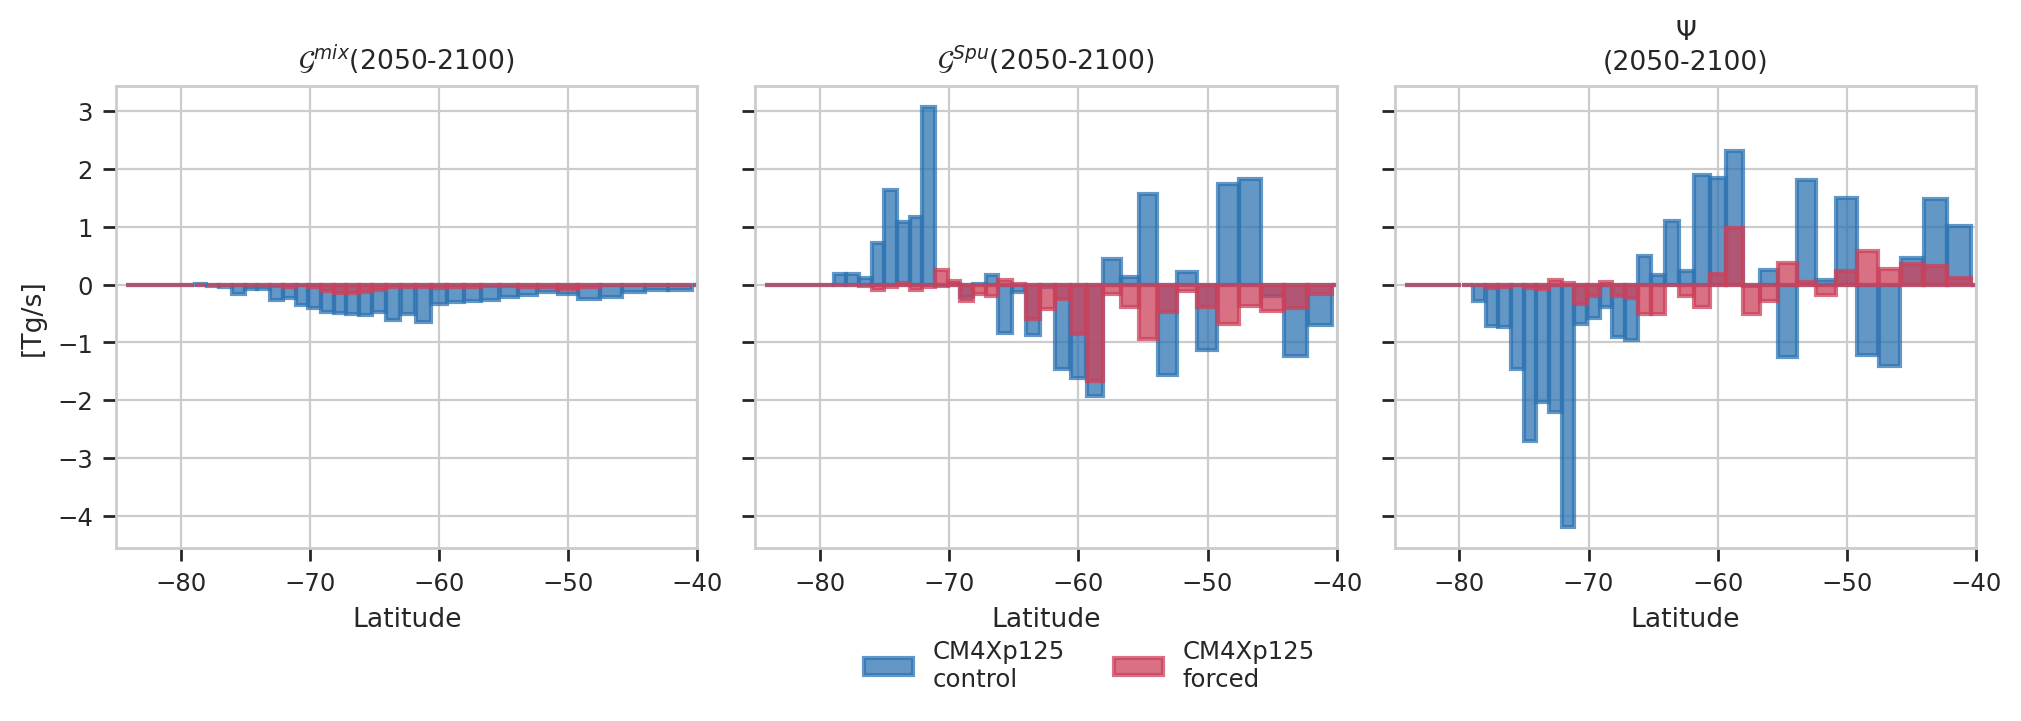

In [26]:
mass_flux_units = "Tg/s"
mass_flux_units_conversion = toTg

times = ('2050', '2100')
experiments = ['control', 'forced']
fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharey = True, sharex =True)

wmt_mean = ds_sfc.sel(time = slice(times[0], times[1])).mean("time")
vmax = np.abs(wmt_mean["spurious_numerical_mixing"]).max().values

variables = ["diffusion", "spurious_numerical_mixing", "convergent_mass_transport"]
# labels = ["Mass Flux from Diffusion\n" + '-'.join(times) + "\n" + r"$\mathbf{(\sigma_2 \geq 37.0)}$", 
#           "Mass Flux from Spurious Mixing\n" + '-'.join(times) + "\n" + r"$\mathbf{(\sigma_2 \geq 37.0)}$", 
#           "Mass Flux from Transport Convergence\n" + '-'.join(times) + "\n" + r"$\mathbf{(\sigma_2 \geq 37.0)}$"]

labels = [r"$\mathcal{G}^{mix}$" + "(" + '-'.join(times) + ")",
                  r"$\mathcal{G}^{Spu}$" + "(" + '-'.join(times) + ")",
                  r"$\Psi$" + "\n" + "(" + '-'.join(times) + ")"]
for (i, expt) in enumerate(experiments):
    for (j, var) in enumerate(variables):
        ax = axes[j]
        print(expt)
        print(var)

        wmt_mean_budget =  mass_flux_units_conversion * wmt_mean.sel(exp = expt)[var]
        wmt_mean_budget = wmt_mean_budget.where(wmt_mean_budget != 0.0).sum("xh")
        latitudes = wmt_mean["geolat"].mean("xh")
        bin_widths = np.concatenate([np.diff(latitudes)[[0]], np.diff(latitudes)])
        
        # ax.plot(latitudes,wmt_mean_budget, linewidth = 1.5, alpha = 0.9, c = expt_colors[expt],
        #               label = f"CM4Xp125\n{expt}", 
        #        marker = "o", markersize = 2)
        # ax.fill_between(latitudes, wmt_mean_budget, linewidth = 1.5, alpha = 0.5, color = expt_colors[expt])
        ax.bar(latitudes,wmt_mean_budget, linewidth = 1.5, alpha = 0.75, width = bin_widths, 
               color = expt_colors[expt],
               edgecolor=expt_colors[expt], label = f"CM4Xp125\n{expt}")
        # print(ds_3d.sel(exp = expt)["spurious_numerical_mixing"].sel(sigma2_l_target = sigma, method = "nearest").sum())
    
        ax.set_xlim((-85, -40))
        ax.tick_params(bottom=True, left=True)
        ax.set_xlabel("Latitude")
        ax.set_title(labels[j])

axes[1].legend(ncols = 2, bbox_to_anchor = (1, -0.15), frameon = False)
axes[0].set_ylabel(f"[{mass_flux_units}]")
fig.subplots_adjust(wspace = 0.1)

control
boundary_fluxes_salt
control
boundary_fluxes_heat
forced
boundary_fluxes_salt
forced
boundary_fluxes_heat


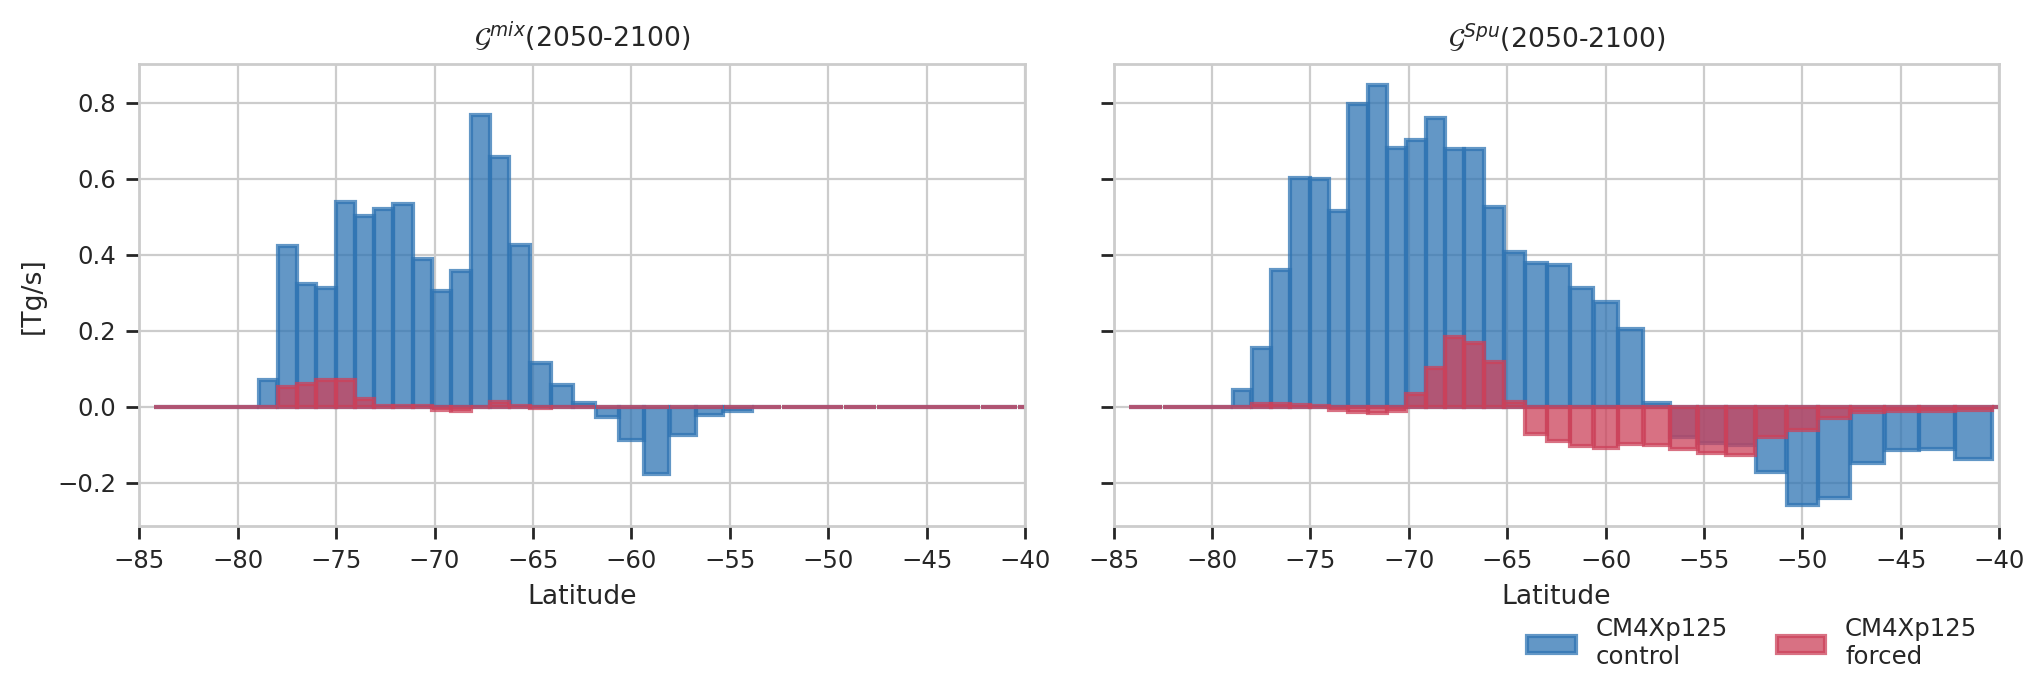

In [27]:
mass_flux_units = "Tg/s"
mass_flux_units_conversion = toTg

times = ('2050', '2100')
experiments = ['control', 'forced']
fig, axes = plt.subplots(1, 2, figsize=(12, 3), sharey = True, sharex =True)

wmt_mean = ds_sfc.sel(time = slice(times[0], times[1])).mean("time")
vmax = np.abs(wmt_mean["spurious_numerical_mixing"]).max().values

variables = ["boundary_fluxes_salt", "boundary_fluxes_heat"]
# labels = ["Mass Flux from Diffusion\n" + '-'.join(times) + "\n" + r"$\mathbf{(\sigma_2 \geq 37.0)}$", 
#           "Mass Flux from Spurious Mixing\n" + '-'.join(times) + "\n" + r"$\mathbf{(\sigma_2 \geq 37.0)}$", 
#           "Mass Flux from Transport Convergence\n" + '-'.join(times) + "\n" + r"$\mathbf{(\sigma_2 \geq 37.0)}$"]

labels = [r"$\mathcal{G}^{mix}$" + "(" + '-'.join(times) + ")",
                  r"$\mathcal{G}^{Spu}$" + "(" + '-'.join(times) + ")",
                  r"$\Psi$" + "\n" + "(" + '-'.join(times) + ")"]
for (i, expt) in enumerate(experiments):
    for (j, var) in enumerate(variables):
        ax = axes[j]
        print(expt)
        print(var)

        wmt_mean_budget =  mass_flux_units_conversion * wmt_mean.sel(exp = expt)[var]
        wmt_mean_budget = wmt_mean_budget.where(wmt_mean_budget != 0.0).sum("xh")
        latitudes = wmt_mean["geolat"].mean("xh")
        bin_widths = np.concatenate([np.diff(latitudes)[[0]], np.diff(latitudes)])
        
        # ax.plot(latitudes,wmt_mean_budget, linewidth = 1.5, alpha = 0.9, c = expt_colors[expt],
        #               label = f"CM4Xp125\n{expt}", 
        #        marker = "o", markersize = 2)
        # ax.fill_between(latitudes, wmt_mean_budget, linewidth = 1.5, alpha = 0.5, color = expt_colors[expt])
        ax.bar(latitudes,wmt_mean_budget, linewidth = 1.5, alpha = 0.75, width = bin_widths, 
               color = expt_colors[expt],
               edgecolor=expt_colors[expt], label = f"CM4Xp125\n{expt}")
        # print(ds_3d.sel(exp = expt)["spurious_numerical_mixing"].sel(sigma2_l_target = sigma, method = "nearest").sum())
    
        ax.set_xlim((-85, -40))
        ax.tick_params(bottom=True, left=True)
        ax.set_xlabel("Latitude")
        ax.set_title(labels[j])

axes[1].legend(ncols = 2, bbox_to_anchor = (1, -0.15), frameon = False)
axes[0].set_ylabel(f"[{mass_flux_units}]")
fig.subplots_adjust(wspace = 0.1)